## Section 1: Analysis and t-test without covariables

In [6]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_ind, levene
import pingouin as pg

np.random.seed(12)

In [7]:
def threshold_matrix(matrix, threshold_percentage): # (what for, check the other script when drawing network?)
    
    # Flatten the matrix to array
    flat_matrix = matrix.flatten()
    
    # Get the number of elements in the flattened matrix
    n = flat_matrix.shape[0]
    
    # Sort the flattened matrix in ascending order
    sorted_matrix = np.sort(flat_matrix)
    
    # Choose the location in matrix, the location is the nth * threshold percentage
    threshold_value = sorted_matrix[int(n * threshold_percentage)]
    
    # Create a boolean mask based on the threshold value
    mask = matrix >= threshold_value
    
    # Apply the boolean mask to the matrix to threshold the values
    # >= threshold_value: True and keep, < threshold_value to 0
    thresholded_matrix = np.where(mask, matrix, 0)
    
    # thresholded_matrix = np.where(mask, 1, 0)
    return thresholded_matrix


In [8]:
import os
import numpy as np
import pandas as pd
import math

def calculateSubjAdj(path_to_data, roi_list_file, groupnum):
    
    # Initialize subject_list
    with open('subject_list.txt', 'r') as f:
        subject_ids = [line.strip() for line in f.readlines()]
    
    # Read ROI names from CSV file
    roi_names_df = pd.read_csv(roi_list_file)
    ROIs2use = roi_names_df['ROI_names'].tolist()

    # Initialize variables: matrix subject numbers * roi numbers
    SLI_all = np.zeros((len(subject_ids), len(ROIs2use)))
    SLD_all = np.zeros((len(subject_ids), len(ROIs2use)))
    SubjList = []

    n = 0  # Counter for valid subjects

    for subject_id in subject_ids:
        ts_data_subject = []
        for roi in ROIs2use:
            if subject_id.startswith(groupnum):
                ts_data_file = f"{subject_id}_{roi}.txt"
                
                # Path_to_data needs to be input in func
                ts_data_path = os.path.join(path_to_data, ts_data_file)
            
                # Print the constructed path for debugging
                print(f"Constructed file path: {ts_data_path}")

                if not os.path.exists(ts_data_path):
                    print(f"Warning: File {ts_data_file} not found for subject {subject_id}. Skipping.")
                    continue

                ts_data = np.loadtxt(ts_data_path)
                # Append all rois ts for one subject
                ts_data_subject.append(ts_data)
            
            else:
                print(f"{subject_id} doesn't belong to the required group.")
            
        ROIsTC2use = np.array(ts_data_subject)
        print(f"Subject {subject_id}: ROIsTC2use shape: {ROIsTC2use.shape}") # ROIsTC2use: (num_ROIs, num_timepoints) for each subject in loop

        if ROIsTC2use.shape[0] == 8:  # 8 ROIs as rows
            if ROIsTC2use.shape[1] > 100:  
                ROIsTC2use_transpose = ROIsTC2use.transpose() # (number of time points, number of rois)

                df = pd.DataFrame(ROIsTC2use_transpose)
                corrMatrix = df.corr()
                corrMatrix[corrMatrix == 1] = 0.99  # set the diagonal as 0.99
                np.fill_diagonal(corrMatrix.values, 1) # reset to 1

                R = corrMatrix.values  # correlation matrix values

                cols = len(ROIs2use)  # number of ROIs

                # influencing degree matrix
                important_variable = np.zeros((cols, cols))
                important_variable_std = np.zeros((cols, cols))
                important_variable_mean = np.zeros((cols, cols))
                
                Do_z = 1  # z-score operation condition
                
                # i, j, ind: 3 nodes
                for i in range(0, cols):
                    for j in range(0, cols):
                        for ind in range(0, cols):
                            # Partial correlation coefficient
                            if (ind != i) & (ind != j) & (i != j):
                                corr = (R[i][j] - R[i][ind] * R[j][ind]) / (math.sqrt((1 - R[i][ind] ** 2) * (1 - R[j][ind] ** 2)))
                                if Do_z == 1:
                                    # Fisher's z-transformation
                                    data_z = math.atanh(R[i][j])
                                    corr_z = math.atanh(corr)
                                    # The correlation influence
                                    diff = data_z - corr_z
                                else:
                                    diff = R[i][j] - corr

                                if diff < 0:
                                    important_variable[j, ind] = 0
                                else:
                                    # Correlation influence between nodes after getting rid of the corr of the 3rd node
                                    # roi*roi
                                    important_variable[j, ind] = diff
                    # Calulate the D (mean of important variable)
                    for t in range(0, cols):
                        if i != t:
                            # All mean and std for the same column are the same, roi*roi
                            temp = important_variable[:, t]
                            important_variable_std[i, t] = np.nanstd(temp)
                            important_variable_mean[i, t] = np.nanmean(temp)
                        else:
                            # Diagonal is 0
                            important_variable_std[i, t] = 0
                            important_variable_mean[i, t] = 0

                np.fill_diagonal(important_variable_mean, 0)
                # Influencing degree: sum of D
                SLI = np.nansum(important_variable_mean, axis=0) #axis=0: calculate the sum of each column
                SLI_all[n, :] = SLI # SLI array input in each subject row
                # Dependency matrix is asymmetrical (
                # It seems to be wrong, because we should calculate the mean based on i first rather than mean calcualtion then transpose to do the sum???
                SLD = np.nansum(important_variable_mean.transpose(), axis=0)
                SLD_all[n, :] = SLD
                SubjList.append(subject_id)
                n += 1 # for each subject

    # Trim excess initialized rows to ensure correct returned data length n valid subjects
    SLI_all = SLI_all[:n, :]
    SLD_all = SLD_all[:n, :]
    SubjList = SubjList[:n]

    return SLI_all, SLD_all, ROIs2use, SubjList


In [9]:
FolderPath = '/Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata'
roi_list_file = '/Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/ROIs_names_K01.csv'
group = 'MDD' # 'HC'

if group == 'HC':
    groupnum = '5' 
if group == 'MDD':
    groupnum = '4'   

# [SLI_all_1, SLD_all_1,ROIsLables2use, SubjList] = calculateSubjAdj(FolderPath,groupNum)
[SLI_all_1, SLD_all_1, ROIsLables2use, SubjList] = calculateSubjAdj(FolderPath, roi_list_file, groupnum)

# Influence and dependence
SLI_all = pd.DataFrame(SLI_all_1)
# Set column index as rois
SLI_all.columns = ROIsLables2use
SLI_all.insert(0, 'SubjList', SubjList)
# Insert subject id as row index
SLI_all.to_csv('K01_SLI_all_' + group + '_test.csv', index=False)

SLD_all = pd.DataFrame(SLD_all_1)
SLD_all.columns = ROIsLables2use
SLD_all.insert(0, 'SubjList', SubjList)
SLD_all.to_csv('K01_SLD_all_' + group + '_test.csv', index=False)


Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_VTA_mni.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_vmPFC2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_cg_3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestSta

Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/409_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/409_vmPFC2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/409_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/409_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/409_cg_3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/409_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/409_amyg.txt
Subject 409: ROIsTC2use shape: (8, 286)
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_M

Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/436_amyg.txt
Subject 436: ROIsTC2use shape: (8, 420)
501 doesn't belong to the required group.
501 doesn't belong to the required group.
501 doesn't belong to the required group.
501 doesn't belong to the required group.
501 doesn't belong to the required group.
501 doesn't belong to the required group.
501 doesn't belong to the required group.
501 doesn't belong to the required group.
Subject 501: ROIsTC2use shape: (0,)
502 doesn't belong to the required group.
502 doesn't belong to the required group.
502 doesn't belong to the required group.
502 doesn't belong to the required group.
502 doesn't belong to the required group.
502 doesn't belong to the required group.
502 doesn't belong to the required group.
502 doesn't belong to the required group.
Subject 502: ROIsTC2use shape: (0,)
503 doesn't belong to the required group.
503 doesn't belong to the required group.
503 do

In [10]:
# function adding 3d-D matrix (subject, 2*2 matrix of important variable mean)
def calculateSubjAdj(path_to_data, roi_list_file, groupnum):
    # Initialize subject_list
    with open('subject_list.txt', 'r') as f:
        subject_ids = [line.strip() for line in f.readlines()]

    # Read ROI names from CSV file
    roi_names_df = pd.read_csv(roi_list_file)
    ROIs2use = roi_names_df['ROI_names'].tolist()

    # Initialize variables: matrix subject numbers * roi numbers
    SLI_all = np.zeros((len(subject_ids), len(ROIs2use)))
    SLD_all = np.zeros((len(subject_ids), len(ROIs2use)))
    important_variable_means = []  # List to store each subject's important_variable_mean matrix
    SubjList = []

    n = 0  # Counter for valid subjects

    for subject_id in subject_ids:
        ts_data_subject = []
        for roi in ROIs2use:
            if subject_id.startswith(groupnum):
                ts_data_file = f"{subject_id}_{roi}.txt"
                
                # Path_to_data needs to be input in func
                ts_data_path = os.path.join(path_to_data, ts_data_file)
            
                # Print the constructed path for debugging
                print(f"Constructed file path: {ts_data_path}")

                if not os.path.exists(ts_data_path):
                    print(f"Warning: File {ts_data_file} not found for subject {subject_id}. Skipping.")
                    continue

                ts_data = np.loadtxt(ts_data_path)
                # Append all rois ts for one subject
                ts_data_subject.append(ts_data)
            
            else:
                print(f"{subject_id} doesn't belong to the required group.")
            
        ROIsTC2use = np.array(ts_data_subject)
        print(f"Subject {subject_id}: ROIsTC2use shape: {ROIsTC2use.shape}") # ROIsTC2use: (num_ROIs, num_timepoints) for each subject in loop

        if ROIsTC2use.shape[0] == 8:  # 8 ROIs as rows
            if ROIsTC2use.shape[1] > 100:  
                ROIsTC2use_transpose = ROIsTC2use.transpose() # (number of time points, number of rois)

                df = pd.DataFrame(ROIsTC2use_transpose)
                corrMatrix = df.corr()
                corrMatrix[corrMatrix == 1] = 0.99  # set the diagonal as 0.99
                np.fill_diagonal(corrMatrix.values, 1) # reset to 1

                R = corrMatrix.values  # correlation matrix values

                cols = len(ROIs2use)  # number of ROIs

                # influencing degree matrix
                important_variable = np.zeros((cols, cols))
                important_variable_std = np.zeros((cols, cols))
                important_variable_mean = np.zeros((cols, cols))
                
                Do_z = 1  # z-score operation condition
                
                # i, j, ind: 3 nodes
                for i in range(0, cols):
                    for j in range(0, cols):
                        for ind in range(0, cols):
                            # Partial correlation coefficient
                            if (ind != i) & (ind != j) & (i != j):
                                corr = (R[i][j] - R[i][ind] * R[j][ind]) / (math.sqrt((1 - R[i][ind] ** 2) * (1 - R[j][ind] ** 2)))
                                if Do_z == 1:
                                    # Fisher's z-transformation
                                    data_z = math.atanh(R[i][j])
                                    corr_z = math.atanh(corr)
                                    # The correlation influence
                                    diff = data_z - corr_z
                                else:
                                    diff = R[i][j] - corr

                                if diff < 0:
                                    important_variable[j, ind] = 0
                                else:
                                    # Correlation influence between nodes after getting rid of the corr of the 3rd node
                                    # roi*roi
                                    important_variable[j, ind] = diff
                    # Calulate the D (mean of important variable)
                    for t in range(0, cols):
                        if i != t:
                            # All mean and std for the same column are the same, roi*roi
                            temp = important_variable[:, t]
                            important_variable_std[i, t] = np.nanstd(temp)
                            important_variable_mean[i, t] = np.nanmean(temp)
                        else:
                            # Diagonal is 0
                            important_variable_std[i, t] = 0
                            important_variable_mean[i, t] = 0

                np.fill_diagonal(important_variable_mean, 0)
                # Influencing degree: sum of D
                SLI = np.nansum(important_variable_mean, axis=0) #axis=0: calculate the sum of each column
                SLI_all[n, :] = SLI # SLI array input in each subject row
                # Dependency matrix is asymmetrical (
                # It seems to be wrong, because we should calculate the mean based on i first rather than mean calcualtion then transpose to do the sum???
                SLD = np.nansum(important_variable_mean.transpose(), axis=0)
                SLD_all[n, :] = SLD
                important_variable_means.append(important_variable_mean)  # Store each subject's important_variable_mean
                SubjList.append(subject_id)
                n += 1 # for each subject

    # Trim excess initialized rows to ensure correct returned data length n valid subjects
    SLI_all = SLI_all[:n, :]
    SLD_all = SLD_all[:n, :]
    SubjList = SubjList[:n]

    important_variable_means = np.array(important_variable_means)  # Convert to numpy array

    return SLI_all, SLD_all, ROIs2use, SubjList, important_variable_means


In [11]:
# Calculate subject adjacency matrices
SLI_all_1, SLD_all_1, ROIsLables2use, SubjList, important_variable_means = calculateSubjAdj(FolderPath, roi_list_file, groupnum)

# Influence and dependence
SLI_all = pd.DataFrame(SLI_all_1)
# Set column index as ROIs
SLI_all.columns = ROIsLables2use
SLI_all.insert(0, 'SubjList', SubjList)
# Insert subject id as row index
SLI_all.to_csv('K01_SLI_all_' + group + '_new.csv', index=False)

SLD_all = pd.DataFrame(SLD_all_1)
SLD_all.columns = ROIsLables2use
SLD_all.insert(0, 'SubjList', SubjList)
SLD_all.to_csv('K01_SLD_all_' + group + '_new.csv', index=False)

# important_variable_means is now available for further analysis
print("Shape of important_variable_means:", important_variable_means.shape)

FolderPath = '/Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata'
roi_list_file = '/Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/ROIs_names_K01.csv'

# Define groups
groups = ['MDD', 'HC']
groupnums = {'MDD': '4', 'HC': '5'}

# Initialize storage for important_variable_means for both groups
important_variable_means_MDD = None
important_variable_means_HC = None

for group in groups:
    groupnum = groupnums[group]

    # Calculate subject adjacency matrices
    SLI_all_1, SLD_all_1, ROIsLables2use, SubjList, important_variable_means = calculateSubjAdj(FolderPath, roi_list_file, groupnum)

    # Influence and dependence
    SLI_all = pd.DataFrame(SLI_all_1)
    # Set column index as ROIs
    SLI_all.columns = ROIsLables2use
    SLI_all.insert(0, 'SubjList', SubjList)
    # Insert subject id as row index
    SLI_all.to_csv(f'K01_SLI_all_{group}_new.csv', index=False)

    SLD_all = pd.DataFrame(SLD_all_1)
    SLD_all.columns = ROIsLables2use
    SLD_all.insert(0, 'SubjList', SubjList)
    SLD_all.to_csv(f'K01_SLD_all_{group}_new.csv', index=False)

    # Store important_variable_means for the group
    if group == 'MDD':
        important_variable_means_MDD = important_variable_means
        subject_list_MDD = SubjList
    elif group == 'HC':
        important_variable_means_HC = important_variable_means
        subject_list_HC = SubjList
        
    print(f"Shape of important_variable_means for {group}:", important_variable_means.shape)


Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_VTA_mni.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_vmPFC2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_cg_3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestSta

Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/408_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/408_vmPFC2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/408_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/408_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/408_cg_3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/408_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/408_amyg.txt
Subject 408: ROIsTC2use shape: (8, 286)
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_M

Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/436_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/436_vmPFC2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/436_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/436_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/436_cg_3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/436_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/436_amyg.txt
Subject 436: ROIsTC2use shape: (8, 420)
501 doesn't belong to the required group.
501 doesn't belong

Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/406_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/406_vmPFC2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/406_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/406_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/406_cg_3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/406_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/406_amyg.txt
Subject 406: ROIsTC2use shape: (8, 420)
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_M

Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/428_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/428_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/428_cg_3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/428_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/428_amyg.txt
Subject 428: ROIsTC2use shape: (8, 286)
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/429_VTA_mni.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/429_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_

Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/548_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/548_vmPFC2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/548_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/548_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/548_cg_3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/548_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/548_amyg.txt
Subject 548: ROIsTC2use shape: (8, 286)
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_M

Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/515_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/515_vmPFC2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/515_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/515_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/515_cg_3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/515_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/515_amyg.txt
Subject 515: ROIsTC2use shape: (8, 286)
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_M

In [12]:
important_variable_means_HC

array([[[0.00000000e+00, 0.00000000e+00, 1.12133826e-03, ...,
         4.32078170e-02, 1.55168806e-02, 0.00000000e+00],
        [6.13538293e-04, 0.00000000e+00, 2.45231405e-01, ...,
         1.29997581e-01, 2.09205886e-01, 7.18530203e-02],
        [1.34592203e-03, 1.20389113e-01, 0.00000000e+00, ...,
         1.55619019e-01, 2.72394348e-01, 9.22824161e-02],
        ...,
        [2.23561653e-03, 1.12807822e-01, 2.12153911e-01, ...,
         0.00000000e+00, 1.53722728e-01, 3.26280621e-02],
        [0.00000000e+00, 1.52499544e-01, 2.95680742e-01, ...,
         1.18624168e-01, 0.00000000e+00, 8.85085075e-02],
        [4.01062537e-03, 1.03946049e-01, 1.87086627e-01, ...,
         4.97525195e-02, 3.69567133e-01, 0.00000000e+00]],

       [[0.00000000e+00, 1.39730847e-01, 2.58567710e-02, ...,
         9.97227574e-03, 1.44570198e-01, 1.41727898e-01],
        [2.07053761e-02, 0.00000000e+00, 3.35680910e-01, ...,
         2.06776787e-01, 2.40470111e-01, 3.21849966e-01],
        [3.02260281e-03, 

In [13]:
import numpy as np

# Check if any NaN values exist in the array
contains_nan = np.isnan(important_variable_means_HC).any()
print("Does important_variable_means_HC contain NaN values?", contains_nan)


Does important_variable_means_HC contain NaN values? False


In [14]:
import numpy as np

# Check if any NaN values exist in the array
contains_nan = np.isnan(important_variable_means_MDD).any()
print("Does important_variable_means_MDD contain NaN values?", contains_nan)


Does important_variable_means_MDD contain NaN values? False


In [15]:
# To be noticed: important_variable_means diagonal is 0
import numpy as np
from scipy.stats import ttest_ind, levene
import pingouin as pg

# Get the dimensions of the matrices
num_subjects, i_size, j_size = important_variable_means_HC.shape

# Initialize arrays to store t-values, p-values, and Cohen's d values for each element [i, j]
t_values = np.zeros((i_size, j_size))
p_values = np.zeros((i_size, j_size))
cohen_d = np.zeros((i_size, j_size))

# Perform t-test for each element [i, j]
for i in range(i_size):
    for j in range(j_size):
        if i != j:  # Exclude diagonal elements
            # Extract values for HC and MDD groups
            healthy_values = important_variable_means_HC[:, i, j]
            patient_values = important_variable_means_MDD[:, i, j]

            # Perform Levene's test for equality of variances
            _, p_var = levene(healthy_values, patient_values)

            # Decide which t-test to use based on Levene's test
            if p_var > 0.05:
                # Variances are equal, use standard t-test
                t_statistic, p_value = ttest_ind(healthy_values, patient_values, equal_var=True)
            else:
                # Variances are not equal, use Welch's t-test
                t_statistic, p_value = ttest_ind(healthy_values, patient_values, equal_var=False)

            # Store the t-value and p-value
            t_values[i, j] = t_statistic
            p_values[i, j] = p_value

            # Calculate Cohen's d value
            cohen_d[i, j] = pg.compute_effsize(healthy_values, patient_values, eftype='cohen')
        else:
            # If diagonal, set t-value, p-value, and Cohen's d to NaN or some placeholder
            t_values[i, j] = np.nan
            p_values[i, j] = np.nan
            cohen_d[i, j] = np.nan

# Output results
print("T-values matrix:")
print(t_values)

print("P-values matrix:")
print(p_values)

print("Cohen's d matrix:")
print(cohen_d)


T-values matrix:
[[        nan -1.02496916 -1.15351825 -1.6909008  -1.10436555 -0.06620948
  -0.61352195 -0.39917692]
 [-1.30986798         nan -1.18525047 -0.39187028  0.24156618 -0.84552445
  -0.93504139  0.88427216]
 [-1.20670537 -0.74003455         nan -0.17326247 -1.08213157 -1.4852956
  -0.86769303  0.8742642 ]
 [-1.26411767  0.01212368 -1.63092904         nan -1.23724044 -1.21494958
  -0.08045748  1.26102025]
 [-1.49807407  0.61078053 -1.55692105 -0.47423797         nan -1.24837368
  -0.7456795   1.53629073]
 [-1.58062722 -0.38795825 -1.30765551 -0.78361625 -1.14294775         nan
  -0.90298246  1.58725531]
 [-1.45388601 -0.39094304 -0.58228146  0.19987908 -1.57220676  0.00965821
          nan  0.70345549]
 [-1.60162605 -0.36063856 -1.31191555 -0.04352036 -0.65551523  0.70254683
  -1.48073703         nan]]
P-values matrix:
[[       nan 0.30858703 0.25226578 0.0949     0.27287374 0.94738266
  0.54133947 0.69086782]
 [0.19413504        nan 0.23956352 0.69623653 0.80975848 0.400437

In [16]:
# ttest for SLD and SLI
import numpy as np
from scipy.stats import ttest_ind, levene
import pingouin as pg

# Define groups
groups = ['MDD', 'HC']
groupnums = {'MDD': '4', 'HC': '5'}

# Initialize storage for important_variable_means for both groups
SLI_all_MDD = None
SLI_all_HC = None
SLD_all_MDD = None
SLD_all_HC = None

for group in groups:
    groupnum = groupnums[group]

    # Calculate subject adjacency matrices
    SLI_all, SLD_all, ROIsLables2use, SubjList, important_variable_means = calculateSubjAdj(FolderPath, roi_list_file, groupnum)

    # Store SLI and SLD matrices based on the group
    if group == 'MDD':
        SLI_all_MDD = SLI_all
        SLD_all_MDD = SLD_all
        subject_list_MDD = SubjList
    elif group == 'HC':
        SLI_all_HC = SLI_all
        SLD_all_HC = SLD_all
        subject_list_HC = SubjList
        
    print(f"Shape of important_variable_means for {group}:", important_variable_means.shape)

import numpy as np
from scipy.stats import ttest_ind, levene
import pingouin as pg

# Get the dimensions of SLI and SLD matrices
roi_count_SLI = SLI_all_MDD.shape[1]
roi_count_SLD = SLD_all_MDD.shape[1]

# Initialize arrays to store t-values, p-values, and Cohen's d values
t_values_SLI = np.zeros((roi_count_SLI, roi_count_SLI))
p_values_SLI = np.zeros((roi_count_SLI, roi_count_SLI))
cohen_d_SLI = np.zeros((roi_count_SLI, roi_count_SLI))

t_values_SLD = np.zeros((roi_count_SLD, roi_count_SLD))
p_values_SLD = np.zeros((roi_count_SLD, roi_count_SLD))
cohen_d_SLD = np.zeros((roi_count_SLD, roi_count_SLD))

# Perform t-test for each element [i, j] in SLI
for i in range(roi_count_SLI):
    for j in range(roi_count_SLI):
        if i != j:  # Exclude diagonal elements
            # Extract SLI values for HC and MDD groups
            healthy_SLI_values = SLI_all_HC[:, i]
            patient_SLI_values = SLI_all_MDD[:, i]

            # Perform Levene's test for equality of variances
            _, p_var_SLI = levene(healthy_SLI_values, patient_SLI_values)

            # Decide which t-test to use based on Levene's test
            if p_var_SLI > 0.05:
                # Variances are equal, use standard t-test
                t_statistic_SLI, p_value_SLI = ttest_ind(healthy_SLI_values, patient_SLI_values, equal_var=True)
            else:
                # Variances are not equal, use Welch's t-test
                t_statistic_SLI, p_value_SLI = ttest_ind(healthy_SLI_values, patient_SLI_values, equal_var=False)

            # Store the t-value and p-value
            t_values_SLI[i, j] = t_statistic_SLI
            p_values_SLI[i, j] = p_value_SLI

            # Calculate Cohen's d value
            cohen_d_SLI[i, j] = pg.compute_effsize(healthy_SLI_values, patient_SLI_values, eftype='cohen')
        else:
            # For diagonal elements, set t-value, p-value, and Cohen's d to NaN
            t_values_SLI[i, j] = np.nan
            p_values_SLI[i, j] = np.nan
            cohen_d_SLI[i, j] = np.nan

# Perform t-test for each element [i, j] in SLD
for i in range(roi_count_SLD):
    for j in range(roi_count_SLD):
        if i != j:  # Exclude diagonal elements
            # Extract SLD values for HC and MDD groups
            healthy_SLD_values = SLD_all_HC[:, i]
            patient_SLD_values = SLD_all_MDD[:, i]

            # Perform Levene's test for equality of variances
            _, p_var_SLD = levene(healthy_SLD_values, patient_SLD_values)

            # Decide which t-test to use based on Levene's test
            if p_var_SLD > 0.05:
                # Variances are equal, use standard t-test
                t_statistic_SLD, p_value_SLD = ttest_ind(healthy_SLD_values, patient_SLD_values, equal_var=True)
            else:
                # Variances are not equal, use Welch's t-test
                t_statistic_SLD, p_value_SLD = ttest_ind(healthy_SLD_values, patient_SLD_values, equal_var=False)

            # Store the t-value and p-value
            t_values_SLD[i, j] = t_statistic_SLD
            p_values_SLD[i, j] = p_value_SLD

            # Calculate Cohen's d value
            cohen_d_SLD[i, j] = pg.compute_effsize(healthy_SLD_values, patient_SLD_values, eftype='cohen')
        else:
            # For diagonal elements, set t-value, p-value, and Cohen's d to NaN
            t_values_SLD[i, j] = np.nan
            p_values_SLD[i, j] = np.nan
            cohen_d_SLD[i, j] = np.nan

# Output results
print("SLI T-values matrix:")
print(t_values_SLI)

print("SLI P-values matrix:")
print(p_values_SLI)

print("SLI Cohen's d matrix:")
print(cohen_d_SLI)

print("SLD T-values matrix:")
print(t_values_SLD)

print("SLD P-values matrix:")
print(p_values_SLD)

print("SLD Cohen's d matrix:")
print(cohen_d_SLD)


Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_VTA_mni.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_vmPFC2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_cg_3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestSta

Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/408_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/408_vmPFC2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/408_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/408_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/408_cg_3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/408_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/408_amyg.txt
Subject 408: ROIsTC2use shape: (8, 286)
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_M

Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/435_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/435_vmPFC2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/435_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/435_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/435_cg_3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/435_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/435_amyg.txt
Subject 435: ROIsTC2use shape: (8, 286)
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_M

Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/506_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/506_vmPFC2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/506_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/506_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/506_cg_3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/506_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/506_amyg.txt
Subject 506: ROIsTC2use shape: (8, 286)
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_M

SLI T-values matrix:
[[        nan -1.69752257 -1.69752257 -1.69752257 -1.69752257 -1.69752257
  -1.69752257 -1.69752257]
 [-0.39597899         nan -0.39597899 -0.39597899 -0.39597899 -0.39597899
  -0.39597899 -0.39597899]
 [-1.40475502 -1.40475502         nan -1.40475502 -1.40475502 -1.40475502
  -1.40475502 -1.40475502]
 [-0.49509991 -0.49509991 -0.49509991         nan -0.49509991 -0.49509991
  -0.49509991 -0.49509991]
 [-1.10397324 -1.10397324 -1.10397324 -1.10397324         nan -1.10397324
  -1.10397324 -1.10397324]
 [-0.76646615 -0.76646615 -0.76646615 -0.76646615 -0.76646615         nan
  -0.76646615 -0.76646615]
 [-0.99612834 -0.99612834 -0.99612834 -0.99612834 -0.99612834 -0.99612834
          nan -0.99612834]
 [ 1.09227241  1.09227241  1.09227241  1.09227241  1.09227241  1.09227241
   1.09227241         nan]]
SLI P-values matrix:
[[       nan 0.09542063 0.09542063 0.09542063 0.09542063 0.09542063
  0.09542063 0.09542063]
 [0.69321564        nan 0.69321564 0.69321564 0.69321564

In [17]:
# Save to excel with 3 sheets
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, levene
import pingouin as pg

# Get the dimensions of the matrices
num_subjects, i_size, j_size = important_variable_means_HC.shape

# Initialize arrays to store t-values, p-values, and Cohen's d values for each element [i, j]
t_values = np.zeros((i_size, j_size))
p_values = np.zeros((i_size, j_size))
cohen_d = np.zeros((i_size, j_size))

# Perform t-test for each element [i, j]
for i in range(i_size):
    for j in range(j_size):
        if i != j:  # Exclude diagonal elements
            # Extract values for HC and MDD groups
            healthy_values = important_variable_means_HC[:, i, j]
            patient_values = important_variable_means_MDD[:, i, j]

            # Perform Levene's test for equality of variances
            _, p_var = levene(healthy_values, patient_values)

            # Decide which t-test to use based on Levene's test
            if p_var > 0.05:
                # Variances are equal, use standard t-test
                t_statistic, p_value = ttest_ind(healthy_values, patient_values, equal_var=True)
            else:
                # Variances are not equal, use Welch's t-test
                t_statistic, p_value = ttest_ind(healthy_values, patient_values, equal_var=False)

            # Store the t-value and p-value
            t_values[i, j] = t_statistic
            p_values[i, j] = p_value

            # Calculate Cohen's d value
            cohen_d[i, j] = pg.compute_effsize(healthy_values, patient_values, eftype='cohen')
        else:
            # If diagonal, set t-value, p-value, and Cohen's d to NaN or some placeholder
            t_values[i, j] = np.nan
            p_values[i, j] = np.nan
            cohen_d[i, j] = np.nan

# Create a DataFrame for each matrix
labels = [(i, j) for i in range(i_size) for j in range(j_size) if i != j]

t_values_df = pd.DataFrame(t_values, index=[f'Row_{i}' for i in range(i_size)], columns=[f'Col_{j}' for j in range(j_size)])
p_values_df = pd.DataFrame(p_values, index=[f'Row_{i}' for i in range(i_size)], columns=[f'Col_{j}' for j in range(j_size)])
cohen_d_df = pd.DataFrame(cohen_d, index=[f'Row_{i}' for i in range(i_size)], columns=[f'Col_{j}' for j in range(j_size)])

# Save results to an Excel file
with pd.ExcelWriter('statistical_results.xlsx') as writer:
    t_values_df.to_excel(writer, sheet_name='T-values')
    p_values_df.to_excel(writer, sheet_name='P-values')
    cohen_d_df.to_excel(writer, sheet_name='Cohen_d')

print("Results have been saved to 'statistical_results.xlsx'.")


Results have been saved to 'statistical_results.xlsx'.


In [18]:
# Save to 3 csv files
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, levene
import pingouin as pg

# Get the dimensions of the matrices
num_subjects, i_size, j_size = important_variable_means_HC.shape

# Initialize arrays to store t-values, p-values, and Cohen's d values for each element [i, j]
t_values = np.zeros((i_size, j_size))
p_values = np.zeros((i_size, j_size))
cohen_d = np.zeros((i_size, j_size))

# Perform t-test for each element [i, j]
for i in range(i_size):
    for j in range(j_size):
        if i != j:  # Exclude diagonal elements
            # Extract values for HC and MDD groups
            healthy_values = important_variable_means_HC[:, i, j]
            patient_values = important_variable_means_MDD[:, i, j]

            # Perform Levene's test for equality of variances
            _, p_var = levene(healthy_values, patient_values)

            # Decide which t-test to use based on Levene's test
            if p_var > 0.05:
                # Variances are equal, use standard t-test
                t_statistic, p_value = ttest_ind(healthy_values, patient_values, equal_var=True)
            else:
                # Variances are not equal, use Welch's t-test
                t_statistic, p_value = ttest_ind(healthy_values, patient_values, equal_var=False)

            # Store the t-value and p-value
            t_values[i, j] = t_statistic
            p_values[i, j] = p_value

            # Calculate Cohen's d value
            cohen_d[i, j] = pg.compute_effsize(healthy_values, patient_values, eftype='cohen')
        else:
            # If diagonal, set t-value, p-value, and Cohen's d to NaN or some placeholder
            t_values[i, j] = np.nan
            p_values[i, j] = np.nan
            cohen_d[i, j] = np.nan

# Create DataFrames for each matrix
labels = [(i, j) for i in range(i_size) for j in range(j_size) if i != j]

t_values_df = pd.DataFrame(t_values, index=[f'Row_{i}' for i in range(i_size)], columns=[f'Col_{j}' for j in range(j_size)])
p_values_df = pd.DataFrame(p_values, index=[f'Row_{i}' for i in range(i_size)], columns=[f'Col_{j}' for j in range(j_size)])
cohen_d_df = pd.DataFrame(cohen_d, index=[f'Row_{i}' for i in range(i_size)], columns=[f'Col_{j}' for j in range(j_size)])

# Save results to CSV files
t_values_df.to_csv('/Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/t_values.csv')
p_values_df.to_csv('/Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/p_values.csv')
cohen_d_df.to_csv('/Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/cohen_d.csv')

print("Results have been saved to 't_values.csv', 'p_values.csv', and 'cohen_d.csv'.")


Results have been saved to 't_values.csv', 'p_values.csv', and 'cohen_d.csv'.


## Section 2: Add covariables

In [1]:
import os
import numpy as np
import pandas as pd
import math

def calculateSubjAdj(path_to_data, roi_list_file):
    # Initialize subject_list
    with open('subject_list.txt', 'r') as f:
        subject_ids = [line.strip() for line in f.readlines()]

    # Read ROI names from CSV file
    roi_names_df = pd.read_csv(roi_list_file)
    ROIs2use = roi_names_df['ROI_names'].tolist()

    # Initialize variables: matrix subject numbers * roi numbers
    SLI_all = np.zeros((len(subject_ids), len(ROIs2use)))
    SLD_all = np.zeros((len(subject_ids), len(ROIs2use)))
    important_variable_means = []  # List to store each subject's important_variable_mean matrix
    SubjList = []

    n = 0  # Counter for valid subjects

    for subject_id in subject_ids:
        ts_data_subject = []
        for roi in ROIs2use:
            ts_data_file = f"{subject_id}_{roi}.txt"
            
            # Construct the full path for the file
            ts_data_path = os.path.join(path_to_data, ts_data_file)
        
            # Print the constructed path for debugging
            print(f"Constructed file path: {ts_data_path}")

            if not os.path.exists(ts_data_path):
                print(f"Warning: File {ts_data_file} not found for subject {subject_id}. Skipping.")
                continue

            ts_data = np.loadtxt(ts_data_path)
            # Append all ROI time series data for one subject
            ts_data_subject.append(ts_data)
        
        ROIsTC2use = np.array(ts_data_subject)
        print(f"Subject {subject_id}: ROIsTC2use shape: {ROIsTC2use.shape}")  # ROIsTC2use: (num_ROIs, num_timepoints) for each subject

        if ROIsTC2use.shape[0] == 8:  # Ensure 8 ROIs as rows
            if ROIsTC2use.shape[1] > 100:  
                ROIsTC2use_transpose = ROIsTC2use.transpose()  # (number of time points, number of ROIs)

                df = pd.DataFrame(ROIsTC2use_transpose)
                corrMatrix = df.corr()
                corrMatrix[corrMatrix == 1] = 0.99  # Set the diagonal as 0.99
                np.fill_diagonal(corrMatrix.values, 1)  # Reset diagonal to 1

                R = corrMatrix.values  # Correlation matrix values

                cols = len(ROIs2use)  # Number of ROIs

                # Initialize influencing degree matrix
                important_variable = np.zeros((cols, cols))
                important_variable_std = np.zeros((cols, cols))
                important_variable_mean = np.zeros((cols, cols))
                
                Do_z = 1  # Z-score operation condition
                
                # Calculate the partial correlation coefficients
                for i in range(cols):
                    for j in range(cols):
                        for ind in range(cols):
                            if (ind != i) & (ind != j) & (i != j):
                                corr = (R[i][j] - R[i][ind] * R[j][ind]) / (math.sqrt((1 - R[i][ind] ** 2) * (1 - R[j][ind] ** 2)))
                                if Do_z == 1:
                                    # Fisher's z-transformation
                                    data_z = math.atanh(R[i][j])
                                    corr_z = math.atanh(corr)
                                    diff = data_z - corr_z
                                else:
                                    diff = R[i][j] - corr

                                if diff < 0:
                                    important_variable[j, ind] = 0
                                else:
                                    important_variable[j, ind] = diff

                    # Calculate the mean and std of important variables
                    for t in range(cols):
                        if i != t:
                            temp = important_variable[:, t]
                            important_variable_std[i, t] = np.nanstd(temp)
                            important_variable_mean[i, t] = np.nanmean(temp)
                        else:
                            important_variable_std[i, t] = 0
                            important_variable_mean[i, t] = 0

                np.fill_diagonal(important_variable_mean, 0)
                # Calculate influencing degree: sum of means
                SLI = np.nansum(important_variable_mean, axis=0)  # Sum of each column
                SLI_all[n, :] = SLI  # Store in SLI array
                SLD = np.nansum(important_variable_mean.transpose(), axis=0)
                SLD_all[n, :] = SLD
                important_variable_means.append(important_variable_mean)  # Store each subject's important_variable_mean
                SubjList.append(subject_id)
                n += 1  # For each valid subject

    # Trim excess initialized rows to ensure correct length of valid subjects
    SLI_all = SLI_all[:n, :]
    SLD_all = SLD_all[:n, :]
    SubjList = SubjList[:n]

    # Convert list of important_variable_mean matrices to numpy array
    important_variable_means = np.array(important_variable_means)  # Shape: (num_subjects, num_ROIs, num_ROIs)

    return SLI_all, SLD_all, ROIs2use, SubjList, important_variable_means

# Define the file paths
FolderPath = '/Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata'
roi_list_file = '/Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/ROIs_names_K01.csv'

# Calculate subject adjacency matrices for all data
SLI_all_1, SLD_all_1, ROIsLables2use, SubjList, important_variable_means = calculateSubjAdj(FolderPath, roi_list_file)

# Influence and dependence
SLI_all = pd.DataFrame(SLI_all_1)
# Set column index as ROIs
SLI_all.columns = ROIsLables2use
SLI_all.insert(0, 'SubjList', SubjList)
# Save to CSV
SLI_all.to_csv('K01_SLI_all_new.csv', index=False)

SLD_all = pd.DataFrame(SLD_all_1)
SLD_all.columns = ROIsLables2use
SLD_all.insert(0, 'SubjList', SubjList)
SLD_all.to_csv('K01_SLD_all_new.csv', index=False)

subject_list_all=SubjList

# Print the shape of important_variable_means for further analysis
print("Shape of important_variable_means:", important_variable_means.shape)


Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_VTA_mni.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_vmPFC2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_cg_3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestSta

Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/545_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/545_vmPFC2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/545_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/545_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/545_cg_3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/545_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/545_amyg.txt
Subject 545: ROIsTC2use shape: (8, 286)
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_M

Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/416_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/416_vmPFC2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/416_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/416_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/416_cg_3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/416_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/416_amyg.txt
Subject 416: ROIsTC2use shape: (8, 286)
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_M

Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/506_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/506_vmPFC2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/506_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/506_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/506_cg_3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/506_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/506_amyg.txt
Subject 506: ROIsTC2use shape: (8, 286)
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_M

Shape of important_variable_means: (79, 8, 8)


In [2]:
# Subj 447 originall not in excel file, but I added it to the bioinfo.
import numpy as np
import pandas as pd

# Load the additional variables from the Excel file
extra_vars_df = pd.read_excel('/Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/Bioinfo.xlsx')

# Extract subject IDs and group information from extra_vars_df
hc_subject_ids = extra_vars_df[extra_vars_df['group'] == 1]['K01_SUBID'].astype(int).tolist()
mdd_subject_ids = extra_vars_df[extra_vars_df['group'] == 0]['K01_SUBID'].astype(int).tolist()

# Ensure subject_list_HC and subject_list_MDD are also lists of integers
subject_list_HC = [int(subj_id) for subj_id in subject_list_HC]
subject_list_MDD = [int(subj_id) for subj_id in subject_list_MDD]

# Find subjects in hc_subject_ids that are not in subject_list_HC
hc_not_in_list = [subj_id for subj_id in hc_subject_ids if subj_id not in subject_list_HC]

# Find subjects in mdd_subject_ids that are not in subject_list_MDD
mdd_not_in_list = [subj_id for subj_id in mdd_subject_ids if subj_id not in subject_list_MDD]

# Find subjects in subject_list_HC that are not in hc_subject_ids
list_not_in_hc = [subj_id for subj_id in subject_list_HC if subj_id not in hc_subject_ids]

# Find subjects in subject_list_MDD that are not in mdd_subject_ids
list_not_in_mdd = [subj_id for subj_id in subject_list_MDD if subj_id not in mdd_subject_ids]

# Output missing subject IDs
if hc_not_in_list:
    print(f"Subjects in HC group from extra variables file but not in subject_list_HC: {hc_not_in_list}")
if mdd_not_in_list:
    print(f"Subjects in MDD group from extra variables file but not in subject_list_MDD: {mdd_not_in_list}")
if list_not_in_hc:
    print(f"Subjects in subject_list_HC but not in HC group from extra variables file: {list_not_in_hc}")
if list_not_in_mdd:
    print(f"Subjects in subject_list_MDD but not in MDD group from extra variables file: {list_not_in_mdd}")

results_df = pd.DataFrame({
    'HC_subjects_not_in_list': pd.Series(hc_not_in_list),
    'MDD_subjects_not_in_list': pd.Series(mdd_not_in_list),
    'Subjects_in_list_not_in_HC': pd.Series(list_not_in_hc),
    'Subjects_in_list_not_in_MDD': pd.Series(list_not_in_mdd)
})

NameError: name 'subject_list_HC' is not defined

In [84]:
# Get common subject list for bioinfo and list of important variables
# Load the additional variables from the Excel file
extra_vars_df = pd.read_excel('/Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/Bioinfo.xlsx')

# Extract subject IDs and group information from extra_vars_df
hc_subject_ids = extra_vars_df[extra_vars_df['group'] == 1]['K01_SUBID'].astype(int).tolist()
mdd_subject_ids = extra_vars_df[extra_vars_df['group'] == 0]['K01_SUBID'].astype(int).tolist()

# Ensure subject_list_HC and subject_list_MDD are also lists of integers
subject_list_HC = [int(subj_id) for subj_id in subject_list_HC]
subject_list_MDD = [int(subj_id) for subj_id in subject_list_MDD]

# Find common subjects between hc_subject_ids and subject_list_HC
common_hc_subjects = [subj_id for subj_id in hc_subject_ids if subj_id in subject_list_HC]

# Find common subjects between mdd_subject_ids and subject_list_MDD
common_mdd_subjects = [subj_id for subj_id in mdd_subject_ids if subj_id in subject_list_MDD]

# Output common subject IDs
print(f"Subjects in HC group that are in both extra variables file and subject_list_HC: {common_hc_subjects}, length {len(common_hc_subjects)}")
print(f"Subjects in MDD group that are in both extra variables file and subject_list_MDD: {common_mdd_subjects}, length {len(common_mdd_subjects)}")

results_df = pd.DataFrame({
    'Common_HC_Subjects': pd.Series(common_hc_subjects),
    'Common_MDD_Subjects': pd.Series(common_mdd_subjects)
})

# use common_hc_subjects and common_mdd_subjects next

Subjects in HC group that are in both extra variables file and subject_list_HC: [501, 502, 503, 504, 506, 507, 508, 514, 515, 516, 517, 519, 520, 522, 523, 524, 525, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 542, 543, 544, 545, 546, 547, 548, 549, 550], length 38
Subjects in MDD group that are in both extra variables file and subject_list_MDD: [401, 402, 406, 408, 409, 410, 413, 415, 416, 417, 418, 419, 420, 421, 422, 424, 425, 427, 428, 429, 430, 431, 432, 434, 435, 436, 438, 439, 440, 441, 442, 443, 444, 445, 446, 450, 451, 453, 454, 455, 447], length 41


In [85]:
# Sort HC and MDD
common_hc_subjects = sorted(common_hc_subjects)
common_mdd_subjects = sorted(common_mdd_subjects)

# Map common subjects to their indices in subject_list_HC and subject_list_MDD
hc_subject_index = {subj_id: idx for idx, subj_id in enumerate(subject_list_HC)}
mdd_subject_index = {subj_id: idx for idx, subj_id in enumerate(subject_list_MDD)}

# Reorder important_variable_means_HC and important_variable_means_MDD based on common subjects
# Ex. 14th subject in important_variable_meansis the 1st in common subjects
hc_reordered_important_means = np.array([important_variable_means_HC[hc_subject_index[subj_id]] for subj_id in common_hc_subjects])
mdd_reordered_important_means = np.array([important_variable_means_MDD[mdd_subject_index[subj_id]] for subj_id in common_mdd_subjects])

# Two datasets of important variables are on the order of common subjects list

In [86]:
# Merge the two sorted lists
combined_subjects = common_hc_subjects + common_mdd_subjects

# Sort the combined list
sorted_combined_subjects = sorted(combined_subjects)

# All reordered_important_variable_means
subject_index_all = {int(subj_id): idx for idx, subj_id in enumerate(subject_list_all) if subj_id.isdigit()}
all_reordered_important_means = np.array([important_variable_means[subject_index_all[subj_id]] for subj_id in sorted_combined_subjects])

all_reordered_important_means.shape


(79, 8, 8)

In [87]:
# Sort covaraibles dataframe
# Load the Excel file
excel_file = '/Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/Bioinfo.xlsx'
df = pd.read_excel(excel_file)

# Separate MDD and HC groups
mdd_df = df[df['group'] == 0].copy()
hc_df = df[df['group'] == 1].copy()

# Ensure common_subjects lists are sorted
common_hc_subjects = sorted(common_hc_subjects)
common_mdd_subjects = sorted(common_mdd_subjects)

# Reorder data based on common subjects
mdd_df = mdd_df.set_index('K01_SUBID').reindex(common_mdd_subjects).reset_index()
hc_df = hc_df.set_index('K01_SUBID').reindex(common_hc_subjects).reset_index()

print(f"Reordered MDD Data shape: {mdd_df.shape}")
print(f"Reordered HC Data shape: {hc_df.shape}")

# Two datasets of covariables are on the order of common subjects list

Reordered MDD Data shape: (41, 10)
Reordered HC Data shape: (38, 10)


In [88]:
# Reorder all covs
# Load the Excel file
excel_file = '/Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/Bioinfo.xlsx'
df = pd.read_excel(excel_file)

# Reorder data based on common subjects
df = df.set_index('K01_SUBID').reindex(sorted_combined_subjects).reset_index()

print(f"Reordered Data shape: {df.shape}")

df

Reordered Data shape: (79, 10)


,K01_SUBID,MAP_ID,SUB_gende_str,SUB_Age_str,subj,group,SUB_gender_1_F_0_M,SUB_Age,Medication_1_yes_0_no,Daw
0,401,492,M,29,401,0,0,29,0,10
1,402,759,M,33,402,0,0,33,0,10
2,406,820,M,35,406,0,0,35,0,10
3,408,849,F,20,408,0,1,20,0,10
4,409,910,M,30,409,0,0,30,0,10
...,...,...,...,...,...,...,...,...,...,...
74,546,1358,M,32,546,1,0,32,0,5
75,547,1364,F,24,547,1,1,24,0,5
76,548,1304,M,30,548,1,0,30,0,5
77,549,1311,M,25,549,1,0,25,0,5


In [89]:
import statsmodels.api as sm

# Prepare the covariates
X = df[['group', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# (num_subjects, 8, 8) to (num_subjects, 64)
Y = all_reordered_important_means.reshape(-1, all_reordered_important_means.shape[1] * all_reordered_important_means.shape[2])

# Fit the model for each ROI (or variable in important_variable_means)
results = []
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)

# Print summary for each ROI
for i, result in enumerate(results):
    print(f"Summary for variable {i}:")
    print(result.summary())
    print("\n")

Summary for variable 0:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 12 Aug 2024   Prob (F-statistic):                nan
Time:                        03:58:27   Log-Likelihood:                    inf
No. Observations:                  79   AIC:                              -inf
Df Residuals:                      73   BIC:                              -inf
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.153
Date:                Mon, 12 Aug 2024   Prob (F-statistic):              0.340
Time:                        03:58:27   Log-Likelihood:                 55.742
No. Observations:                  79   AIC:                            -99.48
Df Residuals:                      73   BIC:                            -85.27
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.19

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                    0.6541
Date:                Mon, 12 Aug 2024   Prob (F-statistic):              0.659
Time:                        03:58:28   Log-Likelihood:                 111.01
No. Observations:                  79   AIC:                            -210.0
Df Residuals:                      73   BIC:                            -195.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.00

/Users/limu/opt/anaconda3/envs/env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/limu/opt/anaconda3/envs/env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1870: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/Users/limu/opt/anaconda3/envs/env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/limu/opt/anaconda3/envs/env/lib/python3.8/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/Users/limu/opt/anaconda3/envs/env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid val

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     1.634
Date:                Mon, 12 Aug 2024   Prob (F-statistic):              0.162
Time:                        03:58:28   Log-Likelihood:                 36.460
No. Observations:                  79   AIC:                            -60.92
Df Residuals:                      73   BIC:                            -46.70
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.29

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.239
Date:                Mon, 12 Aug 2024   Prob (F-statistic):              0.300
Time:                        03:58:28   Log-Likelihood:                 90.569
No. Observations:                  79   AIC:                            -169.1
Df Residuals:                      73   BIC:                            -154.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.07

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                    0.5982
Date:                Mon, 12 Aug 2024   Prob (F-statistic):              0.701
Time:                        03:58:28   Log-Likelihood:                 17.837
No. Observations:                  79   AIC:                            -23.67
Df Residuals:                      73   BIC:                            -9.457
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.36

/Users/limu/opt/anaconda3/envs/env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/limu/opt/anaconda3/envs/env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1870: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/Users/limu/opt/anaconda3/envs/env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/limu/opt/anaconda3/envs/env/lib/python3.8/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/Users/limu/opt/anaconda3/envs/env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid val

In [90]:
# Summary the t and p values for dependency matrix
import pandas as pd
import statsmodels.api as sm

# Prepare the covariates
X = df[['group', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Reshape (num_subjects, 8, 8) to (num_subjects, 64)
Y = all_reordered_important_means.reshape(-1, all_reordered_important_means.shape[1] * all_reordered_important_means.shape[2])

# Store t-values and p-values for the group variable
t_values = []
p_values = []
group_means = {'MDD': [], 'HC': []}

# Fit the model for each ROI (or variable in important_variable_means)
results = []
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)
    
    # Extract t-values and p-values for the group variable
    t_values.append(result.tvalues['group'])
    p_values.append(result.pvalues['group'])
    
    # Calculate mean for each group
    group_0_mean = Y[df['group'] == 0, i].mean()  # Mean for MDD group
    group_1_mean = Y[df['group'] == 1, i].mean()  # Mean for HC group
    group_means['MDD'].append(group_0_mean)
    group_means['HC'].append(group_1_mean)

# Print or save the results
print("Group t-values:", t_values)
print("Group p-values:", p_values)
print("Group means for MDD:", group_means['MDD'])
print("Group means for HC:", group_means['HC'])

# If needed, save these results to DataFrame for further analysis
t_values_df = pd.DataFrame(t_values, columns=['t_value'])
p_values_df = pd.DataFrame(p_values, columns=['p_value'])
group_means_df = pd.DataFrame({
    'MDD_mean': group_means['MDD'],
    'HC_mean': group_means['HC']
})

# # Save to file
# t_values_df.to_csv('t_values.csv', index=False)
# p_values_df.to_csv('p_values.csv', index=False)
# group_means_df.to_csv('group_means.csv', index=False)


Group t-values: [nan, -1.8319832677612466, -1.366245894466613, -1.9359379806907966, -1.866876737499511, -0.7288888747978373, -1.0025053159128703, -0.9498145475603348, -2.137206474757101, nan, -1.5396681467730815, -0.4690274184595916, -0.24409672091449344, -1.4734348083382274, -1.568754774284898, 0.33259543379953244, -1.8481233165851354, -1.7513262779325716, nan, 0.06191603166692095, -1.1704282626666997, -1.6832888541975537, -1.0533951912489505, 0.6053842463896344, -2.0935377185786366, -0.736401050517741, -1.8604132899032673, nan, -1.7038548793275203, -2.082122314418205, 0.19167723438102824, 0.9995050331938103, -2.5863714560207094, 0.11905701443929195, -1.9157543397694832, -0.11079871238486519, nan, -1.3449735985053113, -0.6034537746053785, 1.2866119981884272, -2.675833291777029, -1.2009223759371155, -1.817633433175708, -0.6857985446864883, -1.0850189781877662, nan, -0.728153114264767, 1.2012458054269137, -2.128841874435631, -1.1013164553073547, -0.9616306083003865, 1.002102421778324, -

In [91]:
# add label for improtant variables
import os
import numpy as np
import pandas as pd
import math

def calculateSubjAdj(path_to_data, roi_list_file):
    # Initialize subject_list
    with open('subject_list.txt', 'r') as f:
        subject_ids = [line.strip() for line in f.readlines()]

    # Read ROI names from CSV file
    roi_names_df = pd.read_csv(roi_list_file)
    ROIs2use = roi_names_df['ROI_names'].tolist()

    # Initialize variables: matrix subject numbers * roi numbers
    SLI_all = np.zeros((len(subject_ids), len(ROIs2use)))
    SLD_all = np.zeros((len(subject_ids), len(ROIs2use)))
    important_variable_means = []  # List to store each subject's important_variable_mean matrix
    SubjList = []

    n = 0  # Counter for valid subjects

    for subject_id in subject_ids:
        ts_data_subject = []
        for roi in ROIs2use:
            ts_data_file = f"{subject_id}_{roi}.txt"
            
            # Construct the full path for the file
            ts_data_path = os.path.join(path_to_data, ts_data_file)
        
            # Print the constructed path for debugging
            print(f"Constructed file path: {ts_data_path}")

            if not os.path.exists(ts_data_path):
                print(f"Warning: File {ts_data_file} not found for subject {subject_id}. Skipping.")
                continue

            ts_data = np.loadtxt(ts_data_path)
            # Append all ROI time series data for one subject
            ts_data_subject.append(ts_data)
        
        ROIsTC2use = np.array(ts_data_subject)
        print(f"Subject {subject_id}: ROIsTC2use shape: {ROIsTC2use.shape}")  # ROIsTC2use: (num_ROIs, num_timepoints) for each subject

        if ROIsTC2use.shape[0] == 8:  # Ensure 8 ROIs as rows
            if ROIsTC2use.shape[1] > 100:  # Assuming more than 100 time points as columns
                ROIsTC2use_transpose = ROIsTC2use.transpose()  # (number of time points, number of ROIs)

                df = pd.DataFrame(ROIsTC2use_transpose)
                corrMatrix = df.corr()
                corrMatrix[corrMatrix == 1] = 0.99  # Set the diagonal as 0.99
                np.fill_diagonal(corrMatrix.values, 1)  # Reset diagonal to 1

                R = corrMatrix.values  # Correlation matrix values

                cols = len(ROIs2use)  # Number of ROIs

                # Initialize influencing degree matrix
                important_variable = np.zeros((cols, cols))
                important_variable_std = np.zeros((cols, cols))
                important_variable_mean = np.zeros((cols, cols))
                
                Do_z = 1  # Z-score operation condition
                
                # Calculate the partial correlation coefficients
                for i in range(cols):
                    for j in range(cols):
                        for ind in range(cols):
                            if (ind != i) & (ind != j) & (i != j):
                                corr = (R[i][j] - R[i][ind] * R[j][ind]) / (math.sqrt((1 - R[i][ind] ** 2) * (1 - R[j][ind] ** 2)))
                                if Do_z == 1:
                                    # Fisher's z-transformation
                                    data_z = math.atanh(R[i][j])
                                    corr_z = math.atanh(corr)
                                    diff = data_z - corr_z
                                else:
                                    diff = R[i][j] - corr

                                if diff < 0:
                                    important_variable[j, ind] = 0
                                else:
                                    important_variable[j, ind] = diff

                    # Calculate the mean and std of important variables
                    for t in range(cols):
                        if i != t:
                            temp = important_variable[:, t]
                            important_variable_std[i, t] = np.nanstd(temp)
                            important_variable_mean[i, t] = np.nanmean(temp)
                        else:
                            important_variable_std[i, t] = 0
                            important_variable_mean[i, t] = 0

                np.fill_diagonal(important_variable_mean, 0)
                # Calculate influencing degree: sum of means
                SLI = np.nansum(important_variable_mean, axis=0)  # Sum of each column
                SLI_all[n, :] = SLI  # Store in SLI array
                SLD = np.nansum(important_variable_mean.transpose(), axis=0)
                SLD_all[n, :] = SLD
                important_variable_means.append(important_variable_mean)  # Store each subject's important_variable_mean
                SubjList.append(subject_id)
                n += 1  # For each valid subject

    # Trim excess initialized rows to ensure correct length of valid subjects
    SLI_all = SLI_all[:n, :]
    SLD_all = SLD_all[:n, :]
    SubjList = SubjList[:n]

    # Convert list of important_variable_mean matrices to numpy array
    important_variable_means = np.array(important_variable_means)  # Shape: (num_subjects, num_ROIs, num_ROIs)

    # Flatten the matrix to shape (num_subjects, num_ROIs*num_ROIs)
    num_subjects, num_rois, _ = important_variable_means.shape
    flattened_important_variable_means = important_variable_means.reshape(num_subjects, num_rois * num_rois)

    # Generate ROI labels for the flattened matrix
    roi_labels = [f"{roi1}*{roi2}" for roi1 in ROIs2use for roi2 in ROIs2use]

    return SLI_all, SLD_all, ROIs2use, SubjList, important_variable_means, flattened_important_variable_means, roi_labels

# Define the file paths
FolderPath = '/Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata'
roi_list_file = '/Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/ROIs_names_K01.csv'

# Calculate subject adjacency matrices for all data
SLI_all_1, SLD_all_1, ROIsLables2use, SubjList, important_variable_means, flattened_important_variable_means, roi_labels = calculateSubjAdj(FolderPath, roi_list_file)

# Influence and dependence
SLI_all = pd.DataFrame(SLI_all_1)
# Set column index as ROIs
SLI_all.columns = ROIsLables2use
SLI_all.insert(0, 'SubjList', SubjList)
# Save to CSV
SLI_all.to_csv('K01_SLI_all_new.csv', index=False)

SLD_all = pd.DataFrame(SLD_all_1)
SLD_all.columns = ROIsLables2use
SLD_all.insert(0, 'SubjList', SubjList)
SLD_all.to_csv('K01_SLD_all_new.csv', index=False)

# Save flattened important variable means
flattened_important_variable_means_df = pd.DataFrame(flattened_important_variable_means, columns=roi_labels)
flattened_important_variable_means_df.insert(0, 'SubjList', SubjList)
flattened_important_variable_means_df.to_csv('K01_Important_Variable_Means_Flattened.csv', index=False)

# Print the shape of important_variable_means for further analysis
print("Shape of important_variable_means:", important_variable_means.shape)
print("Shape of flattened_important_variable_means:", flattened_important_variable_means.shape)


Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_VTA_mni.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_vmPFC2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_cg_3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestSta

Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/544_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/544_vmPFC2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/544_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/544_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/544_cg_3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/544_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/544_amyg.txt
Subject 544: ROIsTC2use shape: (8, 286)
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_M

Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/417_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/417_amyg.txt
Subject 417: ROIsTC2use shape: (8, 286)
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/418_VTA_mni.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/418_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/418_vmPFC2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/418_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/418_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laure

Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/508_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/508_vmPFC2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/508_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/508_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/508_cg_3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/508_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/508_amyg.txt
Subject 508: ROIsTC2use shape: (8, 286)
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_M

Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/523_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/523_vmPFC2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/523_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/523_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/523_cg_3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/523_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/523_amyg.txt
Subject 523: ROIsTC2use shape: (8, 286)
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_M

In [104]:
pd.DataFrame(important_variable_means[1])

,0,1,2,3,4,5,6,7
0,0.000000,0.105036,0.052559,0.192847,0.000000,0.027494,0.000000,0.044186
1,0.009379,0.000000,0.424785,0.225655,0.231373,0.344306,0.051997,0.000000
2,0.002333,0.210976,0.000000,0.278045,0.245469,0.465760,0.148341,0.001797
3,0.008321,0.147694,0.307472,0.000000,0.337319,0.424226,0.147704,0.062863
4,0.000981,0.163118,0.242329,0.378964,0.000000,0.351388,0.189072,0.092504
5,0.000857,0.192717,0.363950,0.363658,0.310336,0.000000,0.177063,0.021287
6,0.000981,0.032946,0.295159,0.235429,0.364006,0.281697,0.000000,0.095187
7,0.009414,0.000000,0.034323,0.310924,0.287493,0.125911,0.266054,0.000000


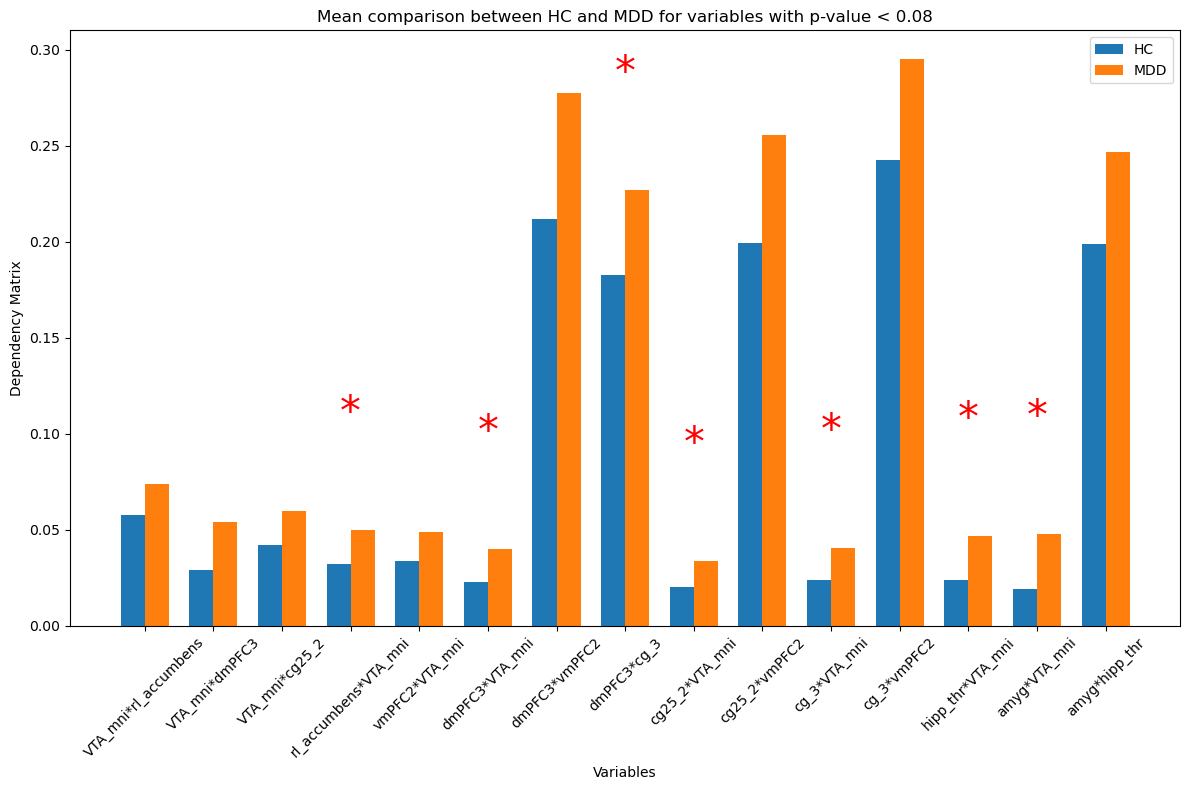

In [92]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

# Load and sort the DataFrame
flattened_important_variable_means_df = pd.read_csv('K01_Important_Variable_Means_Flattened.csv')
sorted_flattened_important_variable_means_df = flattened_important_variable_means_df.sort_values(by='SubjList')

# Prepare the covariates
X = df[['group', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_flattened_important_variable_means_df.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_flattened_important_variable_means_df.columns[1:]

# Initialize lists to store results
t_values = []
p_values = []
group_means = {'MDD': [], 'HC': []}

# Fit the model for each variable
results = []
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)
    
    # Extract t-values and p-values for the group variable
    t_values.append(result.tvalues['group'])
    p_values.append(result.pvalues['group'])
    
    # Calculate mean for each group
    group_0_mean = Y[X['group'] == 0, i].mean()  # Mean for MDD group
    group_1_mean = Y[X['group'] == 1, i].mean()  # Mean for HC group
    group_means['MDD'].append(group_0_mean)
    group_means['HC'].append(group_1_mean)

# Filter variables with p-value <= 0.081
filtered_indices = [i for i, p in enumerate(p_values) if p <= 0.081]
filtered_means = {
    'Variable': [variable_names[i] for i in filtered_indices],
    'MDD_mean': [group_means['MDD'][i] for i in filtered_indices],
    'HC_mean': [group_means['HC'][i] for i in filtered_indices],
    'p_value': [p_values[i] for i in filtered_indices]  # Include p-values for annotation
}

filtered_means_df = pd.DataFrame(filtered_means)

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.35
index = np.arange(len(filtered_means_df))

bar1 = plt.bar(index, filtered_means_df['HC_mean'], bar_width, label='HC')
bar2 = plt.bar(index + bar_width, filtered_means_df['MDD_mean'], bar_width, label='MDD')

plt.xlabel('Variables')
plt.ylabel('Dependency Matrix')
plt.title('Mean comparison between HC and MDD for variables with p-value < 0.08')
plt.xticks(index + bar_width / 2, filtered_means_df['Variable'], rotation=45)
plt.legend()

# Add p-value annotations
for i, p_val in enumerate(filtered_means_df['p_value']):
    if p_val <= 0.05:
        plt.text(index[i] + bar_width / 2, max(filtered_means_df['HC_mean'][i], filtered_means_df['MDD_mean'][i]) + 0.05, '*', 
                 ha='center', va='bottom', fontsize=30, color='red')

plt.tight_layout()
plt.show()

# Save the t-values, p-values, and means to DataFrames
t_values_df = pd.DataFrame(t_values, columns=['t_value'])
p_values_df = pd.DataFrame(p_values, columns=['p_value'])
group_means_df = pd.DataFrame({
    'MDD_mean': group_means['MDD'],
    'HC_mean': group_means['HC']
})

# # Save to file
# t_values_df.to_csv('t_values.csv', index=False)
# p_values_df.to_csv('p_values.csv', index=False)
# group_means_df.to_csv('group_means.csv', index=False)


In [ ]:
# what about between low and high anhedonia

In [94]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Load DataFrame
flattened_important_variable_means_df = pd.read_csv('K01_Important_Variable_Means_Flattened.csv')

# Filter columns containing "VTA"
vta_columns = [col for col in flattened_important_variable_means_df.columns if 'VTA' in col]
vta_df = flattened_important_variable_means_df[['SubjList'] + vta_columns]

# Add 'group' column by merging with 'K01_SUBID' column
vta_df = pd.merge(vta_df, df[['K01_SUBID', 'group']], left_on='SubjList', right_on='K01_SUBID')

# Prepare group data
group_labels = vta_df['group']
vta_data = vta_df.drop(columns=['SubjList', 'group', 'K01_SUBID']).values

# Define function to compute the difference in means between groups
def diff_means(x, y):
    return np.mean(x) - np.mean(y)

# Perform permutation test
num_permutations = 1000
p_values_permutation = []

for i in range(vta_data.shape[1]):
    # Get data for the current column
    col_data = vta_data[:, i]
    
    # Get data for MDD and HC groups
    mdd_data = col_data[group_labels == 0]
    hc_data = col_data[group_labels == 1]
    
    # Compute observed statistic
    observed_stat = diff_means(mdd_data, hc_data)
    
    # Initialize permutation distribution
    perm_distribution = []
    
    # Perform permutations
    for _ in range(num_permutations):
        # Combine data and shuffle labels
        combined_data = np.concatenate([mdd_data, hc_data])
        np.random.shuffle(combined_data)
        
        # Split shuffled data
        perm_mdd_data = combined_data[:len(mdd_data)]
        perm_hc_data = combined_data[len(mdd_data):]
        
        # Compute permutation statistic
        perm_stat = diff_means(perm_mdd_data, perm_hc_data)
        perm_distribution.append(perm_stat)
    
    # Compute p-value
    p_value = np.mean(np.abs(perm_distribution) >= np.abs(observed_stat))
    p_values_permutation.append({'Variable': vta_columns[i], 'p_value': p_value})

# Convert p-value list to DataFrame
p_values_permutation_df = pd.DataFrame(p_values_permutation)

p_values_permutation_df

# # Filter variables with p-value <= 0.081
# filtered_permutation_results = p_values_permutation_df[p_values_permutation_df['p_value'] <= 0.081]

# # Display results
# print(filtered_permutation_results)


,Variable,p_value
0,VTA_mni*VTA_mni,1.000
1,VTA_mni*rl_accumbens,0.311
2,VTA_mni*vmPFC2,0.271
3,VTA_mni*dmPFC3,0.102
4,VTA_mni*cg25_2,0.292
5,VTA_mni*cg_3,0.957
6,VTA_mni*hipp_thr,0.588
7,VTA_mni*amyg,0.712
8,rl_accumbens*VTA_mni,0.190
9,vmPFC2*VTA_mni,0.229


In [99]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression

# Load DataFrame
flattened_important_variable_means_df = pd.read_csv('K01_Important_Variable_Means_Flattened.csv')
# Filter columns containing "VTA"
vta_columns = [col for col in flattened_important_variable_means_df.columns if 'VTA' in col]
vta_df = flattened_important_variable_means_df[['SubjList'] + vta_columns]

# Add group column, merge using K01_SUBID column
vta_df = pd.merge(vta_df, df[['K01_SUBID', 'group', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']], left_on='SubjList', right_on='K01_SUBID')

# Prepare group data
group_labels = vta_df['group']
covariates = vta_df[['SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
vta_data = vta_df.drop(columns=['SubjList', 'group', 'K01_SUBID', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']).values

vta_df

# vta_df.to_csv('/Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/roiroi_df.csv', index=False)


,SubjList,VTA_mni*VTA_mni,VTA_mni*rl_accumbens,VTA_mni*vmPFC2,VTA_mni*dmPFC3,VTA_mni*cg25_2,VTA_mni*cg_3,VTA_mni*hipp_thr,VTA_mni*amyg,rl_accumbens*VTA_mni,...,cg25_2*VTA_mni,cg_3*VTA_mni,hipp_thr*VTA_mni,amyg*VTA_mni,K01_SUBID,group,SUB_gender_1_F_0_M,SUB_Age,Medication_1_yes_0_no,Daw
0,434,0.0,0.100666,0.255526,0.133559,0.000413,0.084190,0.005286,0.005525,0.059172,...,0.004325,0.006531,0.001314,0.003524,434,0,1,23,1,10
1,438,0.0,0.105036,0.052559,0.192847,0.000000,0.027494,0.000000,0.044186,0.009379,...,0.000981,0.000857,0.000981,0.009414,438,0,1,24,0,10
2,439,0.0,0.068031,0.097487,0.078457,0.091548,0.149312,0.139597,0.029300,0.107272,...,0.068336,0.083326,0.091587,0.034019,439,0,0,22,0,10
3,440,0.0,0.077425,0.195369,0.159173,0.039251,0.086159,0.147201,0.091261,0.054313,...,0.042106,0.051744,0.083957,0.084255,440,0,1,35,1,10
4,441,0.0,0.000016,0.041301,0.000388,0.072146,0.002253,0.070231,0.001119,0.000000,...,0.005195,0.000062,0.005868,0.000000,441,0,0,37,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,531,0.0,0.000000,0.056792,0.011340,0.105554,0.054875,0.099991,0.020704,0.000000,...,0.012652,0.010661,0.015299,0.010261,531,1,1,23,0,10
75,533,0.0,0.062316,0.139897,0.037534,0.092851,0.111610,0.091298,0.049128,0.041189,...,0.030871,0.032755,0.030036,0.031575,533,1,1,23,0,10
76,535,0.0,0.052035,0.139602,0.001065,0.049290,0.058220,0.000000,0.003687,0.013857,...,0.009861,0.011225,0.003443,0.006886,535,1,0,23,0,10
77,536,0.0,0.132763,0.082389,0.096362,0.024872,0.151626,0.031749,0.000000,0.016389,...,0.003287,0.016352,0.002775,0.000000,536,1,0,46,0,10


In [437]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression

# Load DataFrame
flattened_important_variable_means_df = pd.read_csv('K01_Important_Variable_Means_Flattened.csv')

# Filter columns containing "VTA"
vta_columns = [col for col in flattened_important_variable_means_df.columns if 'VTA' in col]
vta_df = flattened_important_variable_means_df[['SubjList'] + vta_columns]

# Add group column, merge using K01_SUBID column
vta_df = pd.merge(vta_df, df[['K01_SUBID', 'group', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']], left_on='SubjList', right_on='K01_SUBID')

# Prepare group data
group_labels = vta_df['group']
covariates = vta_df[['SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
vta_data = vta_df.drop(columns=['SubjList', 'group', 'K01_SUBID', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']).values

# Define function to calculate the difference in means between groups
def diff_means(x, y):
    return np.mean(x) - np.mean(y)

# Initialize matrix to store residuals
residuals = np.zeros_like(vta_data)

# Perform regression analysis for each variable, control for covariates, and calculate residuals
for i in range(vta_data.shape[1]):
    col_data = vta_data[:, i]
    
    # Linear regression model
    model = LinearRegression()
    model.fit(covariates, col_data)
    
    # Calculate residuals
    residuals[:, i] = col_data - model.predict(covariates)

# Perform permutation test
num_permutations = 1000
p_values_permutation = []

for i in range(residuals.shape[1]):
    # Get residual data for the current column
    col_data = residuals[:, i]
    
    # Get residual data for MDD and HC groups
    mdd_data = col_data[group_labels == 0]
    hc_data = col_data[group_labels == 1]
    
    # Calculate observed statistic
    observed_stat = diff_means(mdd_data, hc_data)
    
    # Initialize permutation distribution
    perm_distribution = []
    
    # Perform permutations
    for _ in range(num_permutations):
        # Combine residual data and shuffle labels
        combined_data = np.concatenate([mdd_data, hc_data])
        np.random.shuffle(combined_data)
        
        # Split shuffled data
        perm_mdd_data = combined_data[:len(mdd_data)]
        perm_hc_data = combined_data[len(mdd_data):]
        
        # Calculate permutation statistic
        perm_stat = diff_means(perm_mdd_data, perm_hc_data)
        perm_distribution.append(perm_stat)
    
    # Calculate p-value
    p_value = np.mean(np.abs(perm_distribution) >= np.abs(observed_stat))
    p_values_permutation.append({'Variable': vta_columns[i], 'p_value': p_value})

# Convert p-value list to DataFrame
p_values_permutation_df = pd.DataFrame(p_values_permutation)

# Print permutation test results
print("Permutation Test Results:")
print(p_values_permutation_df)

# Filter variables with p-values <= 0.081
filtered_permutation_results = p_values_permutation_df[p_values_permutation_df['p_value'] <= 0.081]

# Display filtered results
print("Filtered Permutation Test Results (p <= 0.081):")
print(filtered_permutation_results)


Permutation Test Results:
                Variable  p_value
0        VTA_mni*VTA_mni    1.000
1   VTA_mni*rl_accumbens    0.144
2         VTA_mni*vmPFC2    0.280
3         VTA_mni*dmPFC3    0.103
4         VTA_mni*cg25_2    0.135
5           VTA_mni*cg_3    0.597
6       VTA_mni*hipp_thr    0.473
7           VTA_mni*amyg    0.459
8   rl_accumbens*VTA_mni    0.097
9         vmPFC2*VTA_mni    0.130
10        dmPFC3*VTA_mni    0.072
11        cg25_2*VTA_mni    0.042
12          cg_3*VTA_mni    0.029
13      hipp_thr*VTA_mni    0.075
14          amyg*VTA_mni    0.047
Filtered Permutation Test Results (p <= 0.081):
            Variable  p_value
10    dmPFC3*VTA_mni    0.072
11    cg25_2*VTA_mni    0.042
12      cg_3*VTA_mni    0.029
13  hipp_thr*VTA_mni    0.075
14      amyg*VTA_mni    0.047


In [105]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests

# Load and sort the DataFrame
flattened_important_variable_means_df = pd.read_csv('K01_Important_Variable_Means_Flattened.csv')
sorted_flattened_important_variable_means_df = flattened_important_variable_means_df.sort_values(by='SubjList')

vta_columns = [col for col in sorted_flattened_important_variable_means_df.columns if 'VTA' in col and 'VTA_mni*VTA_mni' not in col]
sorted_flattened_important_variable_means_df = sorted_flattened_important_variable_means_df[['SubjList'] + vta_columns]

sorted_flattened_important_variable_means_df

,SubjList,VTA_mni*rl_accumbens,VTA_mni*vmPFC2,VTA_mni*dmPFC3,VTA_mni*cg25_2,VTA_mni*cg_3,VTA_mni*hipp_thr,VTA_mni*amyg,rl_accumbens*VTA_mni,vmPFC2*VTA_mni,dmPFC3*VTA_mni,cg25_2*VTA_mni,cg_3*VTA_mni,hipp_thr*VTA_mni,amyg*VTA_mni
30,401,0.016650,0.006845,0.000008,0.011746,0.017325,0.018497,0.003173,0.001329,0.000919,0.000003,0.001015,0.001463,0.001479,0.000715
31,402,0.197591,0.307238,0.001669,0.083964,0.108337,0.440251,0.088607,0.081616,0.076178,0.000000,0.039322,0.044770,0.084621,0.320806
32,406,0.033791,0.300188,0.034326,0.140806,0.238471,0.190204,0.006123,0.035523,0.062389,0.056427,0.057088,0.089402,0.075976,0.018261
33,408,0.218173,0.151329,0.103260,0.263325,0.286773,0.191461,0.002703,0.188631,0.173595,0.159242,0.217117,0.207449,0.174789,0.028700
34,409,0.396321,0.284657,0.421231,0.038805,0.231377,0.419994,0.386639,0.379125,0.327585,0.467464,0.000000,0.250300,0.521093,0.591514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,546,0.050313,0.063512,0.012592,0.006288,0.059733,0.046227,0.006755,0.016740,0.014156,0.003192,0.002199,0.011732,0.013612,0.006662
21,547,0.039256,0.019403,0.014543,0.016246,0.000730,0.087153,0.088966,0.018727,0.007108,0.008681,0.004274,0.000188,0.017790,0.025544
22,548,0.168972,0.414498,0.172410,0.000000,0.047323,0.079637,0.000427,0.023550,0.037226,0.010410,0.004950,0.000000,0.000000,0.004950
23,549,0.066828,0.051816,0.001085,0.103506,0.060040,0.098011,0.062070,0.020565,0.018589,0.001808,0.020582,0.020383,0.024033,0.034746


In [432]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests

# Load and sort the DataFrame
flattened_important_variable_means_df = pd.read_csv('K01_Important_Variable_Means_Flattened.csv')
sorted_flattened_important_variable_means_df = flattened_important_variable_means_df.sort_values(by='SubjList')

vta_columns = [col for col in sorted_flattened_important_variable_means_df.columns if 'VTA' in col and 'VTA_mni*VTA_mni' not in col]
sorted_flattened_important_variable_means_df = sorted_flattened_important_variable_means_df[['SubjList'] + vta_columns]

# Prepare the covariates
X = df[['group', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, num_variables)
Y = sorted_flattened_important_variable_means_df.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_flattened_important_variable_means_df.columns[1:]

# Initialize lists to store results
t_values = []
p_values = []
group_means = {'MDD': [], 'HC': []}

# Fit the model for each variable
results = []
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)
    
    # Extract t-values and p-values for the group variable
    t_values.append(result.tvalues['group'])
    p_values.append(result.pvalues['group'])
    
    # Calculate mean for each group
    group_0_mean = Y[X['group'] == 0, i].mean()  # Mean for MDD group
    group_1_mean = Y[X['group'] == 1, i].mean()  # Mean for HC group
    group_means['MDD'].append(group_0_mean)
    group_means['HC'].append(group_1_mean)

# Apply FDR correction
rejected, p_values_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

# Create DataFrame with corrected p-values
p_values_corrected_df = pd.DataFrame({
    'Variable': variable_names,
    'p_value': p_values,
    'p_value_corrected': p_values_corrected,
    'rejected': rejected
})

# Print FDR corrected p-values
print("FDR Corrected P-Values:")
print(p_values_corrected_df)

# Filter variables with FDR-corrected p-values <= 0.081
filtered_indices = p_values_corrected_df[p_values_corrected_df['p_value_corrected'] <= 0.081].index
filtered_means = {
    'Variable': [variable_names[i] for i in filtered_indices],
    'MDD_mean': [group_means['MDD'][i] for i in filtered_indices],
    'HC_mean': [group_means['HC'][i] for i in filtered_indices],
    'p_value_corrected': [p_values_corrected[i] for i in filtered_indices]
}

filtered_means_df = pd.DataFrame(filtered_means)

# # Plotting the bar chart
# fig, ax = plt.subplots(figsize=(12, 8))
# bar_width = 0.35
# index = np.arange(len(filtered_means_df))

# bar1 = plt.bar(index, filtered_means_df['HC_mean'], bar_width, label='HC')
# bar2 = plt.bar(index + bar_width, filtered_means_df['MDD_mean'], bar_width, label='MDD')

# plt.xlabel('Variables')
# plt.ylabel('Dependency Matrix')
# plt.title('Mean comparison between HC and MDD for variables with FDR-corrected p-value < 0.081')
# plt.xticks(index + bar_width / 2, filtered_means_df['Variable'], rotation=45)
# plt.legend()

# # Add p-value annotations
# for i, p_val in enumerate(filtered_means_df['p_value_corrected']):
#     if p_val <= 0.05:
#         plt.text(index[i] + bar_width / 2, max(filtered_means_df['HC_mean'][i], filtered_means_df['MDD_mean'][i]) + 0.05, '*', 
#                  ha='center', va='bottom', fontsize=30, color='red')

# plt.tight_layout()
# plt.show()

# Save the t-values, p-values, and means to DataFrames
t_values_df = pd.DataFrame(t_values, columns=['t_value'])
p_values_df = pd.DataFrame(p_values, columns=['p_value'])
group_means_df = pd.DataFrame({
    'MDD_mean': group_means['MDD'],
    'HC_mean': group_means['HC']
})

# # Save to file
# t_values_df.to_csv('t_values.csv', index=False)
# p_values_df.to_csv('p_values.csv', index=False)
# group_means_df.to_csv('group_means.csv', index=False)


FDR Corrected P-Values:
                Variable   p_value  p_value_corrected  rejected
0   VTA_mni*rl_accumbens  0.071033           0.099446     False
1         VTA_mni*vmPFC2  0.176056           0.224071     False
2         VTA_mni*dmPFC3  0.056748           0.099446     False
3         VTA_mni*cg25_2  0.065934           0.099446     False
4           VTA_mni*cg_3  0.468402           0.468402     False
5       VTA_mni*hipp_thr  0.319411           0.371905     False
6           VTA_mni*amyg  0.345341           0.371905     False
7   rl_accumbens*VTA_mni  0.035931           0.092808     False
8         vmPFC2*VTA_mni  0.068635           0.099446     False
9         dmPFC3*VTA_mni  0.039775           0.092808     False
10        cg25_2*VTA_mni  0.011692           0.081844     False
11          cg_3*VTA_mni  0.009197           0.081844     False
12      hipp_thr*VTA_mni  0.036642           0.092808     False
13          amyg*VTA_mni  0.027470           0.092808     False


In [3]:
import statsmodels.stats.multitest as smm

# p值列表
pval = [0.071033, 0.176056, 0.056748, 0.065934, 0.468402, 0.319411, 
        0.345341, 0.035931, 0.068635, 0.039775, 0.011692, 0.009197, 
        0.036642, 0.027470]

# 使用 Benjamini/Hochberg (FDR) 方法调整 p 值
reject, pval_corrected, _, _ = smm.multipletests(pval, alpha=0.05, method='fdr_bh')

# 输出结果
print("原始 p 值:", pval)
print("调整后的 p 值:", pval_corrected)
print("是否拒绝原假设:", reject)


原始 p 值: [0.071033, 0.176056, 0.056748, 0.065934, 0.468402, 0.319411, 0.345341, 0.035931, 0.068635, 0.039775, 0.011692, 0.009197, 0.036642, 0.02747]
调整后的 p 值: [0.0994462  0.22407127 0.0994462  0.0994462  0.468402   0.37190569
 0.37190569 0.09280833 0.0994462  0.09280833 0.081844   0.081844
 0.09280833 0.09280833]
是否拒绝原假设: [False False False False False False False False False False False False
 False False]


In [409]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# 加载并排序DataFrame
flattened_important_variable_means_df = pd.read_csv('K01_Important_Variable_Means_Flattened.csv')
sorted_flattened_important_variable_means_df = flattened_important_variable_means_df.sort_values(by='SubjList')

# 筛选包含"VTA"的列
vta_columns = [col for col in sorted_flattened_important_variable_means_df.columns if 'VTA' in col]
vta_df = sorted_flattened_important_variable_means_df[['SubjList', 'group'] + vta_columns]

# 准备分组数据
group_labels = vta_df['group']
vta_data = vta_df.drop(columns=['SubjList', 'group']).values

# 定义计算组间均值差异的函数
def diff_means(x, y):
    return np.mean(x) - np.mean(y)

# 执行排列检验
num_permutations = 10000
p_values_permutation = []

for i in range(vta_data.shape[1]):
    # 获取当前列的数据
    col_data = vta_data[:, i]
    
    # 获取MDD和HC组的数据
    mdd_data = col_data[group_labels == 0]
    hc_data = col_data[group_labels == 1]
    
    # 计算观察到的统计量
    observed_stat = diff_means(mdd_data, hc_data)
    
    # 初始化排列分布
    perm_distribution = []
    
    # 执行排列
    for _ in range(num_permutations):
        # 组合数据并打乱标签
        combined_data = np.concatenate([mdd_data, hc_data])
        np.random.shuffle(combined_data)
        
        # 分离打乱后的数据
        perm_mdd_data = combined_data[:len(mdd_data)]
        perm_hc_data = combined_data[len(mdd_data):]
        
        # 计算排列统计量
        perm_stat = diff_means(perm_mdd_data, perm_hc_data)
        perm_distribution.append(perm_stat)
    
    # 计算p值
    p_value = np.mean(np.abs(perm_distribution) >= np.abs(observed_stat))
    p_values_permutation.append({'Variable': vta_columns[i], 'p_value': p_value})

# 转换p值列表为DataFrame
p_values_permutation_df = pd.DataFrame(p_values_permutation)

# 筛选p值 <= 0.081的变量
filtered_permutation_results = p_values_permutation_df[p_values_permutation_df['p_value'] <= 0.081]

# 显示结果
print(filtered_permutation_results)


KeyError: "['group'] not in index"

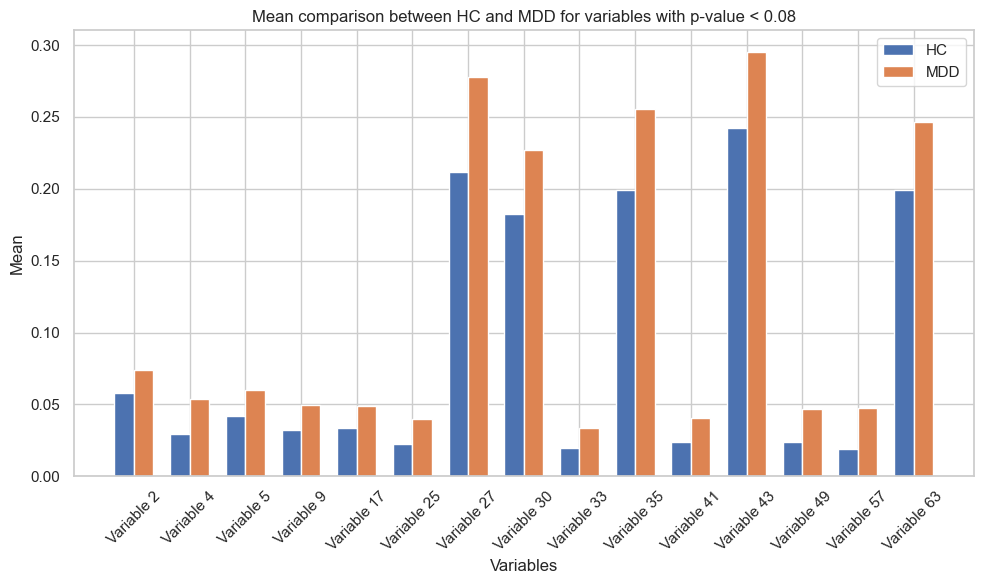

In [323]:
# Bar chart
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

# Prepare the covariates
X = df[['group', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Reshape (num_subjects, 8, 8) to (num_subjects, 64)
Y = all_reordered_important_means.reshape(-1, all_reordered_important_means.shape[1] * all_reordered_important_means.shape[2])

# Store t-values and p-values for the group variable
t_values = []
p_values = []
group_means = {'MDD': [], 'HC': []}
variable_names = []

# Fit the model for each ROI (or variable in important_variable_means)
results = []
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)
    
    # Extract t-values and p-values for the group variable
    t_values.append(result.tvalues['group'])
    p_values.append(result.pvalues['group'])
    
    # Calculate mean for each group
    group_0_mean = Y[df['group'] == 0, i].mean()  # Mean for MDD group
    group_1_mean = Y[df['group'] == 1, i].mean()  # Mean for HC group
    group_means['MDD'].append(group_0_mean)
    group_means['HC'].append(group_1_mean)
    
    # Save variable name
    variable_names.append(f'Variable {i+1}')

# Filter variables with p-value < 0.08
filtered_indices = [i for i, p in enumerate(p_values) if p < 0.08]
filtered_means = {
    'Variable': [variable_names[i] for i in filtered_indices],
    'MDD_mean': [group_means['MDD'][i] for i in filtered_indices],
    'HC_mean': [group_means['HC'][i] for i in filtered_indices]
}

filtered_means_df = pd.DataFrame(filtered_means)

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(filtered_means_df))

bar1 = plt.bar(index, filtered_means_df['HC_mean'], bar_width, label='HC')
bar2 = plt.bar(index + bar_width, filtered_means_df['MDD_mean'], bar_width, label='MDD')

plt.xlabel('Variables')
plt.ylabel('Mean')
plt.title('Mean comparison between HC and MDD for variables with p-value < 0.08')
plt.xticks(index + bar_width / 2, filtered_means_df['Variable'], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Save the t-values, p-values, and means to DataFrames
t_values_df = pd.DataFrame(t_values, columns=['t_value'])
p_values_df = pd.DataFrame(p_values, columns=['p_value'])
group_means_df = pd.DataFrame({
    'MDD_mean': group_means['MDD'],
    'HC_mean': group_means['HC']
})

# # Save to file
# t_values_df.to_csv('t_values.csv', index=False)
# p_values_df.to_csv('p_values.csv', index=False)
# group_means_df.to_csv('group_means.csv', index=False)
# filtered_means_df.to_csv('filtered_means.csv', index=False)


In [324]:
df.isna().any().any()

False

In [325]:
is_dataframe = isinstance(df, pd.DataFrame)

print(is_dataframe) 

True


In [343]:
SLD_all_sorted = SLD_all.sort_values(by='SubjList')
SLD_all_sorted.reset_index()

SLI_all_sorted = SLI_all.sort_values(by='SubjList')
SLI_all_sorted.reset_index()

,index,SubjList,VTA_mni,rl_accumbens,vmPFC2,dmPFC3,cg25_2,cg_3,hipp_thr,amyg
0,30,401,0.006923,0.456863,0.516596,0.032638,0.571683,0.658804,0.735946,0.130790
1,31,402,0.647313,1.505831,4.169292,0.914985,1.373054,2.480839,2.608979,0.211760
2,32,406,0.395066,0.433239,3.178662,0.298012,2.472879,1.748958,2.496555,0.280454
3,33,408,1.149523,1.307564,1.369094,0.676934,1.767202,2.327102,1.763806,0.113666
4,34,409,2.537081,2.695863,2.470753,2.514742,0.179723,1.977465,2.404369,2.002549
...,...,...,...,...,...,...,...,...,...,...
74,20,546,0.068293,0.276869,1.051738,0.920474,0.942045,0.781079,0.741429,0.086195
75,21,547,0.082312,0.268309,0.542467,0.269532,0.582131,0.827182,0.759649,0.696384
76,22,548,0.081087,0.452288,3.516745,1.985191,1.140281,3.330716,2.292241,1.025261
77,23,549,0.140707,0.918065,1.191785,0.566150,1.675675,1.131987,1.742046,0.252004


In [345]:
df

,K01_SUBID,MAP_ID,SUB_gende_str,SUB_Age_str,subj,group,SUB_gender_1_F_0_M,SUB_Age,Medication_1_yes_0_no,Daw
0,401,492,M,29,401,0,0,29,0,10
1,402,759,M,33,402,0,0,33,0,10
2,406,820,M,35,406,0,0,35,0,10
3,408,849,F,20,408,0,1,20,0,10
4,409,910,M,30,409,0,0,30,0,10
...,...,...,...,...,...,...,...,...,...,...
74,546,1358,M,32,546,1,0,32,0,5
75,547,1364,F,24,547,1,1,24,0,5
76,548,1304,M,30,548,1,0,30,0,5
77,549,1311,M,25,549,1,0,25,0,5


In [357]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Sort and reset index for SLD_all and SLI_all
SLD_all_sorted = SLD_all.sort_values(by='SubjList').reset_index(drop=True)
SLI_all_sorted = SLI_all.sort_values(by='SubjList').reset_index(drop=True)

# Prepare the covariates
X = df[['group', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

SLD_columns = SLD_all_sorted.columns[-8:]
SLI_columns = SLI_all_sorted.columns[-8:]

# Initialize lists to store results
sld_t_values = []
sld_p_values = []
sld_group_means = {'MDD': [], 'HC': []}
sld_summaries = []

sli_t_values = []
sli_p_values = []
sli_group_means = {'MDD': [], 'HC': []}
sli_summaries = []

# Fit the model for SLD_all
for col1 in SLD_columns:
    try:
        Y1 = SLD_all_sorted[col1]
        model = sm.OLS(Y1, X)
        result = model.fit()
        
        # Store t-values and p-values for the group variable
        sld_t_values.append(result.tvalues['group'])
        sld_p_values.append(result.pvalues['group'])
        
        # Store model summary
        sld_summaries.append(result.summary().as_text())
        
        # Calculate mean for each group
        group_0_mean = SLD_all_sorted.loc[X['group'] == 0, col1].mean()  # Mean for MDD group
        group_1_mean = SLD_all_sorted.loc[X['group'] == 1, col1].mean()  # Mean for HC group

        sld_group_means['MDD'].append(group_0_mean)
        sld_group_means['HC'].append(group_1_mean)
    except Exception as e:
        print(f"Error processing SLD column {col1}: {e}")

# Fit the model for SLI_all
for col2 in SLI_columns:
    try:
        Y2 = SLI_all_sorted[col2]
        model = sm.OLS(Y2, X)
        result = model.fit()
        
        # Store t-values and p-values for the group variable
        sli_t_values.append(result.tvalues['group'])
        sli_p_values.append(result.pvalues['group'])
        
        # Store model summary
        sli_summaries.append(result.summary().as_text())
        
        # Calculate mean for each group
        group_0_mean = SLI_all_sorted.loc[X['group'] == 0, col2].mean()  # Mean for MDD group
        group_1_mean = SLI_all_sorted.loc[X['group'] == 1, col2].mean()  # Mean for HC group

        sli_group_means['MDD'].append(group_0_mean)
        sli_group_means['HC'].append(group_1_mean)
    except Exception as e:
        print(f"Error processing SLI column {col2}: {e}")

# Print results
print("SLD t-values:", sld_t_values)
print("SLD p-values:", sld_p_values)
print("SLD group means for MDD:", sld_group_means['MDD'])
print("SLD group means for HC:", sld_group_means['HC'])
print("SLD Summaries:")
for idx, summary in enumerate(sld_summaries):
    print(f"Column {idx} SLD Summary:\n{summary}\n")

print("SLI t-values:", sli_t_values)
print("SLI p-values:", sli_p_values)
print("SLI group means for MDD:", sli_group_means['MDD'])
print("SLI group means for HC:", sli_group_means['HC'])
print("SLI Summaries:")
for idx, summary in enumerate(sli_summaries):
    print(f"Column {idx} SLI Summary:\n{summary}\n")

# Save results to DataFrames for further analysis
sld_t_values_df = pd.DataFrame(sld_t_values, columns=['sld_t_value'])
sld_p_values_df = pd.DataFrame(sld_p_values, columns=['sld_p_value'])
sld_group_means_df = pd.DataFrame({
    'sld_MDD_mean': sld_group_means['MDD'],
    'sld_HC_mean': sld_group_means['HC']
})

sli_t_values_df = pd.DataFrame(sli_t_values, columns=['sli_t_value'])
sli_p_values_df = pd.DataFrame(sli_p_values, columns=['sli_p_value'])
sli_group_means_df = pd.DataFrame({
    'sli_MDD_mean': sli_group_means['MDD'],
    'sli_HC_mean': sli_group_means['HC']
})

# Save to files if needed
# sld_t_values_df.to_csv('sld_t_values.csv', index=False)
# sld_p_values_df.to_csv('sld_p_values.csv', index=False)
# sld_group_means_df.to_csv('sld_group_means.csv', index=False)

# sli_t_values_df.to_csv('sli_t_values.csv', index=False)
# sli_p_values_df.to_csv('sli_p_values.csv', index=False)
# sli_group_means_df.to_csv('sli_group_means.csv', index=False)

# Save model summaries to text files
with open('sld_summaries.txt', 'w') as f:
    for idx, summary in enumerate(sld_summaries):
        f.write(f"Column {idx} SLD Summary:\n{summary}\n\n")

with open('sli_summaries.txt', 'w') as f:
    for idx, summary in enumerate(sli_summaries):
        f.write(f"Column {idx} SLI Summary:\n{summary}\n\n")


SLD t-values: [-1.7753306158178859, -1.4484066054058404, -1.4688036528462673, -1.6393294196675996, -1.0814997803156898, -1.3914242995123338, -0.842774747012714, -1.4756133453011508]
SLD p-values: [0.08001147421248189, 0.15178513400591395, 0.14618230186507236, 0.1054475650879466, 0.2830346562741467, 0.1683226544716774, 0.4021073112228988, 0.14434815120099573]
SLD group means for MDD: [0.5141739604037537, 0.7412063492569165, 0.8903549392974869, 0.9253294038540679, 0.9422625559934056, 0.9500081786881213, 0.9267380676455662, 0.7463404020317738]
SLD group means for HC: [0.4034990478471676, 0.6492578928230782, 0.7671534248469417, 0.7952622281808178, 0.8293504834937927, 0.8237343241741437, 0.843793539151397, 0.6330820227002187]
SLD Summaries:
Column 0 SLD Summary:
                            OLS Regression Results                            
Dep. Variable:                VTA_mni   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0

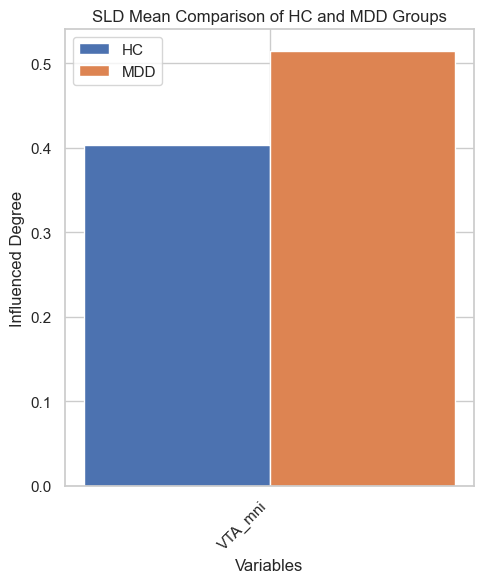

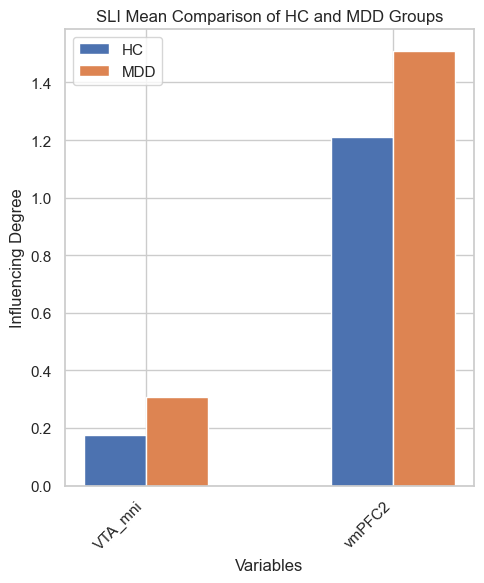

In [394]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Sort and reset index for SLD_all and SLI_all
SLD_all_sorted = SLD_all.sort_values(by='SubjList').reset_index(drop=True)
SLI_all_sorted = SLI_all.sort_values(by='SubjList').reset_index(drop=True)

# Prepare the covariates
X = df[['group', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

SLD_columns = SLD_all_sorted.columns[-8:]
SLI_columns = SLI_all_sorted.columns[-8:]

# Initialize lists to store results
sld_t_values = []
sld_p_values = []
sld_group_means = {'MDD': [], 'HC': []}
sld_summaries = []

sli_t_values = []
sli_p_values = []
sli_group_means = {'MDD': [], 'HC': []}
sli_summaries = []

# Fit the model for SLD_all
for col1 in SLD_columns:
    try:
        Y1 = SLD_all_sorted[col1]
        model = sm.OLS(Y1, X)
        result = model.fit()
        
        # Store t-values and p-values for the group variable
        sld_t_values.append(result.tvalues['group'])
        sld_p_values.append(result.pvalues['group'])
        
        # Store model summary
        sld_summaries.append(result.summary().as_text())
        
        # Calculate mean for each group
        group_0_mean = SLD_all_sorted.loc[X['group'] == 0, col1].mean()  # Mean for MDD group
        group_1_mean = SLD_all_sorted.loc[X['group'] == 1, col1].mean()  # Mean for HC group

        sld_group_means['MDD'].append(group_0_mean)
        sld_group_means['HC'].append(group_1_mean)
    except Exception as e:
        print(f"Error processing SLD column {col1}: {e}")

# Fit the model for SLI_all
for col2 in SLI_columns:
    try:
        Y2 = SLI_all_sorted[col2]
        model = sm.OLS(Y2, X)
        result = model.fit()
        
        # Store t-values and p-values for the group variable
        sli_t_values.append(result.tvalues['group'])
        sli_p_values.append(result.pvalues['group'])
        
        # Store model summary
        sli_summaries.append(result.summary().as_text())
        
        # Calculate mean for each group
        group_0_mean = SLI_all_sorted.loc[X['group'] == 0, col2].mean()  # Mean for MDD group
        group_1_mean = SLI_all_sorted.loc[X['group'] == 1, col2].mean()  # Mean for HC group

        sli_group_means['MDD'].append(group_0_mean)
        sli_group_means['HC'].append(group_1_mean)
    except Exception as e:
        print(f"Error processing SLI column {col2}: {e}")

# Function to plot bar chart for significant variables with adjustable bar width
def plot_significant_bars(group_means, p_values, ylabel, threshold=0.081, title_prefix="", bar_width=0.15):
    significant_indices = [i for i, p in enumerate(p_values) if p <= threshold]
    significant_vars = [SLD_columns[i] for i in significant_indices]

    means_mdd = [group_means['MDD'][i] for i in significant_indices]
    means_hc = [group_means['HC'][i] for i in significant_indices]

    x = np.arange(len(significant_vars))  # the label locations

    fig, ax = plt.subplots(figsize=(5, 6))
    rects1 = ax.bar(x - bar_width/2, means_hc, bar_width, label='HC')
    rects2 = ax.bar(x + bar_width/2, means_mdd, bar_width, label='MDD')

    # Add some text for labels, title and axes ticks
    ax.set_xlabel('Variables')
    ax.set_ylabel(ylabel)
    ax.set_title(f'{title_prefix} Mean Comparison of HC and MDD Groups')
    ax.set_xticks(x)
    ax.set_xticklabels(significant_vars, rotation=45, ha='right')
    ax.legend()

    fig.tight_layout()
    plt.show()

# Plot significant bars for SLD and SLI with different ylabels and bar widths
plot_significant_bars(sld_group_means, sld_p_values, ylabel="Influenced Degree", title_prefix="SLD", bar_width=0.1)
plot_significant_bars(sli_group_means, sli_p_values, ylabel="Influencing Degree", title_prefix="SLI", bar_width=0.25)


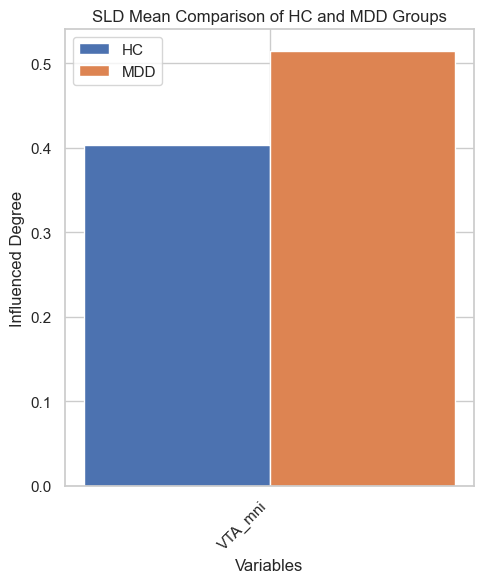

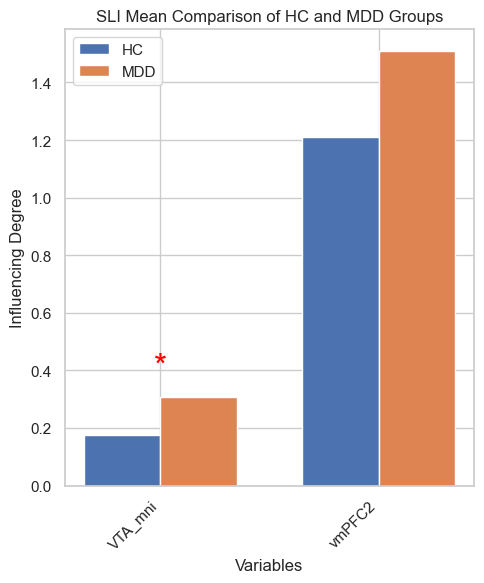

In [400]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Sort and reset index for SLD_all and SLI_all
SLD_all_sorted = SLD_all.sort_values(by='SubjList').reset_index(drop=True)
SLI_all_sorted = SLI_all.sort_values(by='SubjList').reset_index(drop=True)

# Prepare the covariates
X = df[['group', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

SLD_columns = SLD_all_sorted.columns[-8:]
SLI_columns = SLI_all_sorted.columns[-8:]

# Initialize lists to store results
sld_t_values = []
sld_p_values = []
sld_group_means = {'MDD': [], 'HC': []}
sld_summaries = []

sli_t_values = []
sli_p_values = []
sli_group_means = {'MDD': [], 'HC': []}
sli_summaries = []

# Fit the model for SLD_all
for col1 in SLD_columns:
    try:
        Y1 = SLD_all_sorted[col1]
        model = sm.OLS(Y1, X)
        result = model.fit()
        
        # Store t-values and p-values for the group variable
        sld_t_values.append(result.tvalues['group'])
        sld_p_values.append(result.pvalues['group'])
        
        # Store model summary
        sld_summaries.append(result.summary().as_text())
        
        # Calculate mean for each group
        group_0_mean = SLD_all_sorted.loc[X['group'] == 0, col1].mean()  # Mean for MDD group
        group_1_mean = SLD_all_sorted.loc[X['group'] == 1, col1].mean()  # Mean for HC group

        sld_group_means['MDD'].append(group_0_mean)
        sld_group_means['HC'].append(group_1_mean)
    except Exception as e:
        print(f"Error processing SLD column {col1}: {e}")

# Fit the model for SLI_all
for col2 in SLI_columns:
    try:
        Y2 = SLI_all_sorted[col2]
        model = sm.OLS(Y2, X)
        result = model.fit()
        
        # Store t-values and p-values for the group variable
        sli_t_values.append(result.tvalues['group'])
        sli_p_values.append(result.pvalues['group'])
        
        # Store model summary
        sli_summaries.append(result.summary().as_text())
        
        # Calculate mean for each group
        group_0_mean = SLI_all_sorted.loc[X['group'] == 0, col2].mean()  # Mean for MDD group
        group_1_mean = SLI_all_sorted.loc[X['group'] == 1, col2].mean()  # Mean for HC group

        sli_group_means['MDD'].append(group_0_mean)
        sli_group_means['HC'].append(group_1_mean)
    except Exception as e:
        print(f"Error processing SLI column {col2}: {e}")

# Function to plot bar chart for significant variables with adjustable bar width
def plot_significant_bars(group_means, p_values, ylabel, threshold=0.081, significance_threshold=0.05, title_prefix="", bar_width=0.15):
    significant_indices = [i for i, p in enumerate(p_values) if p <= threshold]
    significant_vars = [SLD_columns[i] for i in significant_indices]

    means_mdd = [group_means['MDD'][i] for i in significant_indices]
    means_hc = [group_means['HC'][i] for i in significant_indices]
    p_values_filtered = [p_values[i] for i in significant_indices]

    x = np.arange(len(significant_vars))  # the label locations

    fig, ax = plt.subplots(figsize=(5, 6))
    rects1 = ax.bar(x - bar_width/2, means_hc, bar_width, label='HC')
    rects2 = ax.bar(x + bar_width/2, means_mdd, bar_width, label='MDD')

    # Add some text for labels, title and axes ticks
    ax.set_xlabel('Variables')
    ax.set_ylabel(ylabel)
    ax.set_title(f'{title_prefix} Mean Comparison of HC and MDD Groups')
    ax.set_xticks(x)
    ax.set_xticklabels(significant_vars, rotation=45, ha='right')
    ax.legend()

    # Annotate significant bars with asterisks
    for i, p in enumerate(p_values_filtered):
        if p <= significance_threshold:
            ax.text(x[i], max(means_hc[i], means_mdd[i]) + 0.05, '*', ha='center', va='bottom', color='red', fontsize=24)

    fig.tight_layout()
    plt.show()

# Plot significant bars for SLD and SLI with different ylabels and bar widths
plot_significant_bars(sld_group_means, sld_p_values, ylabel="Influenced Degree", title_prefix="SLD", bar_width=0.1)
plot_significant_bars(sli_group_means, sli_p_values, ylabel="Influencing Degree", title_prefix="SLI", bar_width=0.35)


In [356]:
# Excluding duplicated part
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Prepare the covariates
X = df[['group', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Remove diagonal and keep non-redundant parts
num_subjects = all_reordered_important_means.shape[0]
num_rois = all_reordered_important_means.shape[1]

# Keep only the upper triangular part (excluding the diagonal)
Y = []
for subj_idx in range(num_subjects):
    upper_tri_indices = np.triu_indices(num_rois, k=1)
    Y.append(all_reordered_important_means[subj_idx][upper_tri_indices])

Y = np.array(Y)  # (num_subjects, num_non_diagonal_elements)
num_non_diagonal_elements = Y.shape[1]

# Perform linear regression analysis for each non-diagonal element
results = []
for i in range(num_non_diagonal_elements):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)

# Print the summary results for each ROI
for i, result in enumerate(results):
    print(f"Summary for variable {i}:")
    print(result.summary())
    print("\n")


Summary for variable 0:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     1.838
Date:                Fri, 26 Jul 2024   Prob (F-statistic):              0.116
Time:                        07:50:47   Log-Likelihood:                 103.10
No. Observations:                  79   AIC:                            -194.2
Df Residuals:                      73   BIC:                            -180.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                    0.6395
Date:                Fri, 26 Jul 2024   Prob (F-statistic):              0.670
Time:                        07:50:48   Log-Likelihood:                 85.981
No. Observations:                  79   AIC:                            -160.0
Df Residuals:                      73   BIC:                            -145.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

In [242]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.utils import resample

# Prepare the covariates
X = df[['group', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# (num_subjects, 8, 8) to (num_subjects, 64)
Y = all_reordered_important_means.reshape(-1, all_reordered_important_means.shape[1] * all_reordered_important_means.shape[2])

n_bootstraps = 100  # Number of bootstrap samples
boot_results = np.zeros((Y.shape[1], n_bootstraps))  # Storage for bootstrap results
observed_coefs = np.zeros(Y.shape[1])  # Storage for observed coefficients

# Bootstrap sampling
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    observed_result = model.fit()
    observed_coefs[i] = observed_result.params['group']
    
    for b in range(n_bootstraps):
        # Resample with replacement
        boot_data_idx = resample(np.arange(Y.shape[0]))
        X_boot = X.iloc[boot_data_idx]
        Y_boot = Y[boot_data_idx, i]
        
        # Fit the model
        model = sm.OLS(Y_boot, X_boot)
        result = model.fit()
        
        # Store the group coefficient
        boot_results[i, b] = result.params['group']

# Calculate 95% confidence intervals and p-values
conf_intervals = np.percentile(boot_results, [2.5, 97.5], axis=1)

# Improved p-value calculation
p_values = np.array([
    np.mean(np.abs(boot_results[i, :]) >= np.abs(observed_coefs[i]))
    for i in range(Y.shape[1])
])

# Print the results for each ROI
for i in range(Y.shape[1]):
    print(f"Variable {i}:")
    print(f"95% Confidence Interval for 'group': {conf_intervals[:, i]}")
    print(f"Bootstrap p-value for 'group': {p_values[i]}\n")


Variable 0:
95% Confidence Interval for 'group': [0. 0.]
Bootstrap p-value for 'group': 1.0

Variable 1:
95% Confidence Interval for 'group': [-0.08180453  0.00310892]
Bootstrap p-value for 'group': 0.52

Variable 2:
95% Confidence Interval for 'group': [-0.08910378  0.01521038]
Bootstrap p-value for 'group': 0.52

Variable 3:
95% Confidence Interval for 'group': [-0.08352839  0.00539735]
Bootstrap p-value for 'group': 0.5

Variable 4:
95% Confidence Interval for 'group': [-0.09246901 -0.00528485]
Bootstrap p-value for 'group': 0.56

Variable 5:
95% Confidence Interval for 'group': [-0.0909835   0.02503471]
Bootstrap p-value for 'group': 0.56

Variable 6:
95% Confidence Interval for 'group': [-0.11355837  0.05035745]
Bootstrap p-value for 'group': 0.53

Variable 7:
95% Confidence Interval for 'group': [-0.04790329  0.01683684]
Bootstrap p-value for 'group': 0.38

Variable 8:
95% Confidence Interval for 'group': [-0.08394254 -0.00223691]
Bootstrap p-value for 'group': 0.45

Variable 9:


In [244]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.utils import resample
from statsmodels.stats.multitest import multipletests

# Prepare the covariates
X = df[['group', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# (num_subjects, 8, 8) to (num_subjects, 64)
Y = all_reordered_important_means.reshape(-1, all_reordered_important_means.shape[1] * all_reordered_important_means.shape[2])

n_bootstraps = 100  # Number of bootstrap samples
n_permutations = 1000  # Number of permutation samples

# Initialize storage for bootstrap and permutation results
boot_results = np.zeros((Y.shape[1], n_bootstraps))
observed_coefs = np.zeros(Y.shape[1])

# Bootstrap sampling
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    observed_result = model.fit()
    observed_coefs[i] = observed_result.params['group']
    
    for b in range(n_bootstraps):
        # Resample with replacement
        boot_data_idx = resample(np.arange(Y.shape[0]))
        X_boot = X.iloc[boot_data_idx]
        Y_boot = Y[boot_data_idx, i]
        
        # Fit the model
        model = sm.OLS(Y_boot, X_boot)
        result = model.fit()
        
        # Store the group coefficient
        boot_results[i, b] = result.params['group']

# Calculate 95% confidence intervals for bootstrap results
conf_intervals = np.percentile(boot_results, [2.5, 97.5], axis=1)

# Improved p-value calculation for bootstrap
p_values_boot = np.array([
    np.mean(np.abs(boot_results[i, :]) >= np.abs(observed_coefs[i]))
    for i in range(Y.shape[1])
])

# Permutation test
perm_results = np.zeros(Y.shape[1])
for i in range(Y.shape[1]):
    permuted_coefs = np.zeros(n_permutations)
    for p in range(n_permutations):
        # Shuffle the group labels
        X_perm = X.copy()
        X_perm['group'] = np.random.permutation(X_perm['group'])
        
        # Fit the model with permuted data
        model_perm = sm.OLS(Y[:, i], X_perm)
        result_perm = model_perm.fit()
        
        # Store the permuted group coefficient
        permuted_coefs[p] = result_perm.params['group']
    
    # Calculate p-value for permutation test
    perm_results[i] = np.mean(np.abs(permuted_coefs) >= np.abs(observed_coefs[i]))

# Apply FDR correction to p-values from the bootstrap method
fdr_corrected_p_values_boot = multipletests(p_values_boot, method='fdr_bh')[1]

# Print the results for each ROI
for i in range(Y.shape[1]):
    print(f"Variable {i}:")
    print(f"95% Confidence Interval for 'group' (Bootstrap): {conf_intervals[:, i]}")
    print(f"Bootstrap p-value for 'group': {p_values_boot[i]}")
    print(f"FDR-corrected p-value for 'group': {fdr_corrected_p_values_boot[i]}")
    print(f"Permutation p-value for 'group': {perm_results[i]}\n")


Variable 0:
95% Confidence Interval for 'group' (Bootstrap): [0. 0.]
Bootstrap p-value for 'group': 1.0
FDR-corrected p-value for 'group': 1.0
Permutation p-value for 'group': 1.0

Variable 1:
95% Confidence Interval for 'group' (Bootstrap): [-0.08483433  0.00439649]
Bootstrap p-value for 'group': 0.48
FDR-corrected p-value for 'group': 0.8486956521739131
Permutation p-value for 'group': 0.028

Variable 2:
95% Confidence Interval for 'group' (Bootstrap): [-0.08099253  0.01088846]
Bootstrap p-value for 'group': 0.56
FDR-corrected p-value for 'group': 0.8486956521739131
Permutation p-value for 'group': 0.099

Variable 3:
95% Confidence Interval for 'group' (Bootstrap): [-0.07094107  0.00323613]
Bootstrap p-value for 'group': 0.39
FDR-corrected p-value for 'group': 0.8486956521739131
Permutation p-value for 'group': 0.015

Variable 4:
95% Confidence Interval for 'group' (Bootstrap): [-0.07487461  0.01059462]
Bootstrap p-value for 'group': 0.47
FDR-corrected p-value for 'group': 0.84869565

In [306]:
SLI_all

,VTA_mni,rl_accumbens,vmPFC2,dmPFC3,cg25_2,cg_3,hipp_thr,amyg
0,0.171844,0.285912,1.264411,1.888752,1.211133,1.671565,0.633203,0.258401
1,0.032267,0.852487,1.720577,1.985523,1.775997,2.020781,0.980232,0.317823
2,0.578919,0.318412,0.653885,0.583128,1.268423,1.478523,1.199589,0.537205
3,0.468906,0.833039,2.424447,1.452248,0.542275,1.273139,1.136669,0.679987
4,0.015298,0.056517,0.862889,0.045115,0.961808,0.280645,0.646511,0.039143
...,...,...,...,...,...,...,...,...
74,0.064304,0.114790,1.774883,0.209494,1.503538,1.534426,0.969679,0.282549
75,0.222418,0.319003,2.517614,1.023834,1.497306,1.972688,1.845914,0.554192
76,0.062526,0.316011,1.526482,0.570681,0.634265,0.956885,0.483218,0.008709
77,0.075207,1.708604,2.028073,0.717055,1.962168,1.733164,2.059297,0.715325


In [252]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.utils import resample
from statsmodels.stats.multitest import multipletests

# Prepare the covariates
X = df[['group', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Remove diagonal and redundant parts
num_subjects = all_reordered_important_means.shape[0]
num_rois = all_reordered_important_means.shape[1]

# Keep only the upper triangular part (excluding the diagonal)
Y = []
for subj_idx in range(num_subjects):
    upper_tri_indices = np.triu_indices(num_rois, k=1)
    Y.append(all_reordered_important_means[subj_idx][upper_tri_indices])

Y = np.array(Y)  # (num_subjects, num_non_diagonal_elements)
num_non_diagonal_elements = Y.shape[1]

# Initialize storage for bootstrap and permutation results
boot_results = np.zeros((num_non_diagonal_elements, n_bootstraps))
observed_coefs = np.zeros(num_non_diagonal_elements)

# Bootstrap sampling
for i in range(num_non_diagonal_elements):
    model = sm.OLS(Y[:, i], X)
    observed_result = model.fit()
    observed_coefs[i] = observed_result.params['group']
    
    for b in range(n_bootstraps):
        # Resample with replacement
        boot_data_idx = resample(np.arange(Y.shape[0]))
        X_boot = X.iloc[boot_data_idx]
        Y_boot = Y[boot_data_idx, i]
        
        # Fit the model
        model = sm.OLS(Y_boot, X_boot)
        result = model.fit()
        
        # Store the group coefficient
        boot_results[i, b] = result.params['group']

# Calculate 95% confidence intervals for bootstrap results
conf_intervals = np.percentile(boot_results, [2.5, 97.5], axis=1)

# Improved p-value calculation for bootstrap
p_values_boot = np.array([
    np.mean(np.abs(boot_results[i, :]) >= np.abs(observed_coefs[i]))
    for i in range(num_non_diagonal_elements)
])

# Permutation test
perm_results = np.zeros(num_non_diagonal_elements)
for i in range(num_non_diagonal_elements):
    permuted_coefs = np.zeros(n_permutations)
    for p in range(n_permutations):
        # Shuffle the group labels
        X_perm = X.copy()
        X_perm['group'] = np.random.permutation(X_perm['group'])
        
        # Fit the model with permuted data
        model_perm = sm.OLS(Y[:, i], X_perm)
        result_perm = model_perm.fit()
        
        # Store the permuted group coefficient
        permuted_coefs[p] = result_perm.params['group']
    
    # Calculate p-value for permutation test
    perm_results[i] = np.mean(np.abs(permuted_coefs) >= np.abs(observed_coefs[i]))

# Apply FDR correction to p-values from the bootstrap method
fdr_corrected_p_values_boot = multipletests(p_values_boot, method='fdr_bh')[1]

# Print the results for each ROI
for i in range(num_non_diagonal_elements):
    print(f"Variable {i}:")
    print(f"95% Confidence Interval for 'group' (Bootstrap): {conf_intervals[:, i]}")
    print(f"Bootstrap p-value for 'group': {p_values_boot[i]}")
    print(f"FDR-corrected p-value for 'group': {fdr_corrected_p_values_boot[i]}")
    print(f"Permutation p-value for 'group': {perm_results[i]}\n")


Variable 0:
95% Confidence Interval for 'group' (Bootstrap): [-0.08012707  0.00799989]
Bootstrap p-value for 'group': 0.52
FDR-corrected p-value for 'group': 0.8252631578947369
Permutation p-value for 'group': 0.023

Variable 1:
95% Confidence Interval for 'group' (Bootstrap): [-0.09520201  0.02808009]
Bootstrap p-value for 'group': 0.56
FDR-corrected p-value for 'group': 0.8252631578947369
Permutation p-value for 'group': 0.105

Variable 2:
95% Confidence Interval for 'group' (Bootstrap): [-0.09200806 -0.00192786]
Bootstrap p-value for 'group': 0.45
FDR-corrected p-value for 'group': 0.8252631578947369
Permutation p-value for 'group': 0.013

Variable 3:
95% Confidence Interval for 'group' (Bootstrap): [-0.0864355   0.01621864]
Bootstrap p-value for 'group': 0.43
FDR-corrected p-value for 'group': 0.8252631578947369
Permutation p-value for 'group': 0.032

Variable 4:
95% Confidence Interval for 'group' (Bootstrap): [-0.0921596   0.02691526]
Bootstrap p-value for 'group': 0.51
FDR-corre

In [ ]:
# try bootstrap+permutation?

   group Variable  Value
0      0    Var_0    0.0
1      0    Var_0    0.0
2      0    Var_0    0.0
3      0    Var_0    0.0
4      0    Var_0    0.0


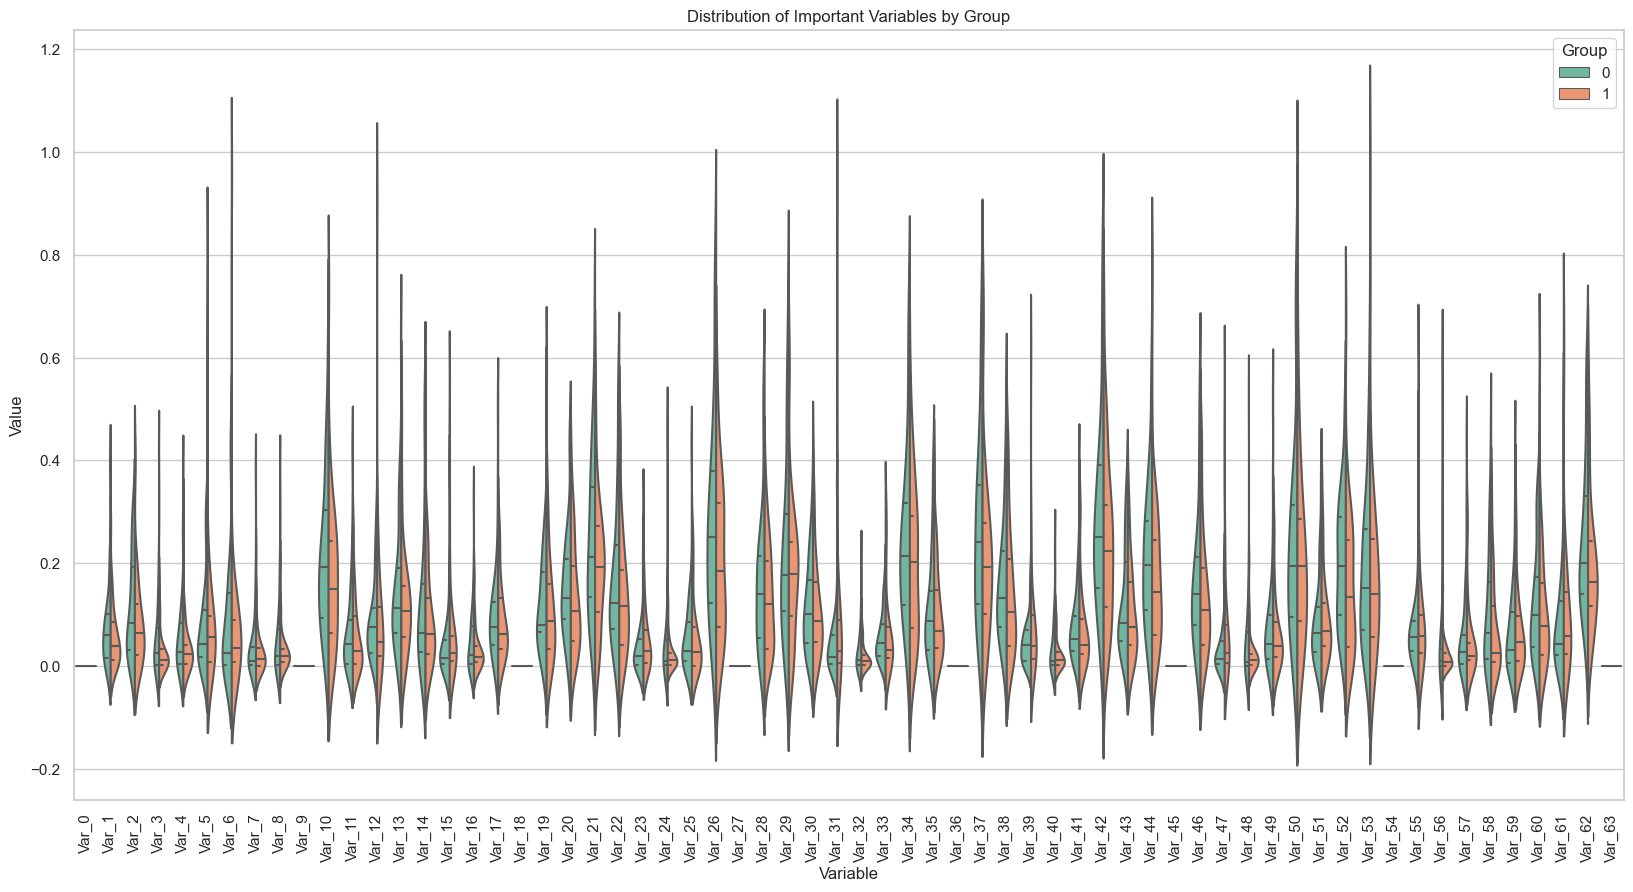

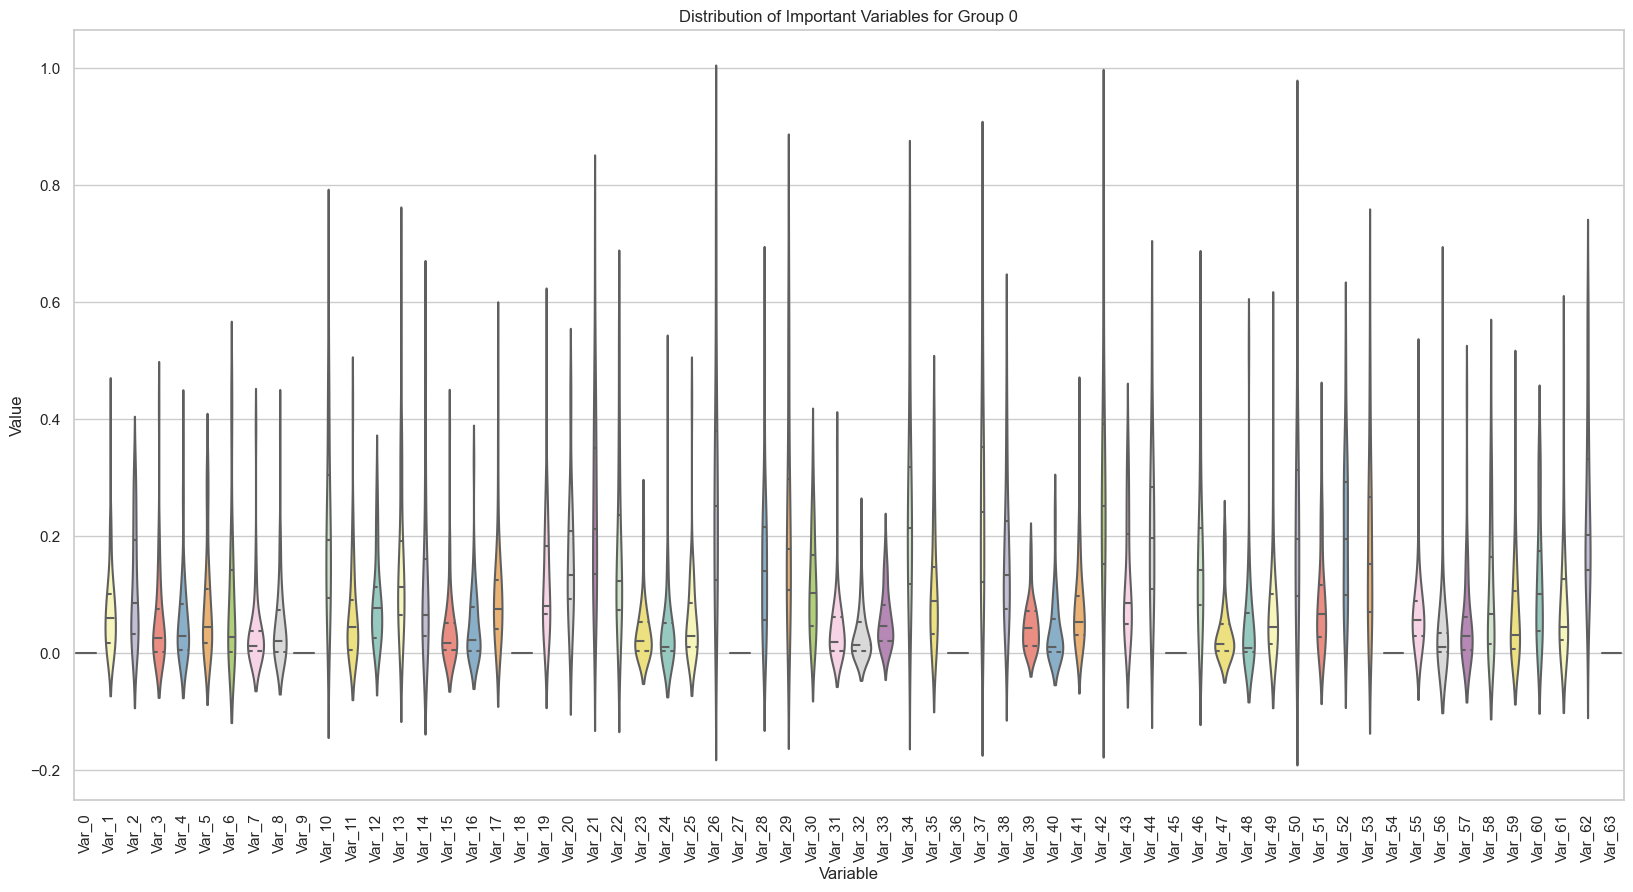

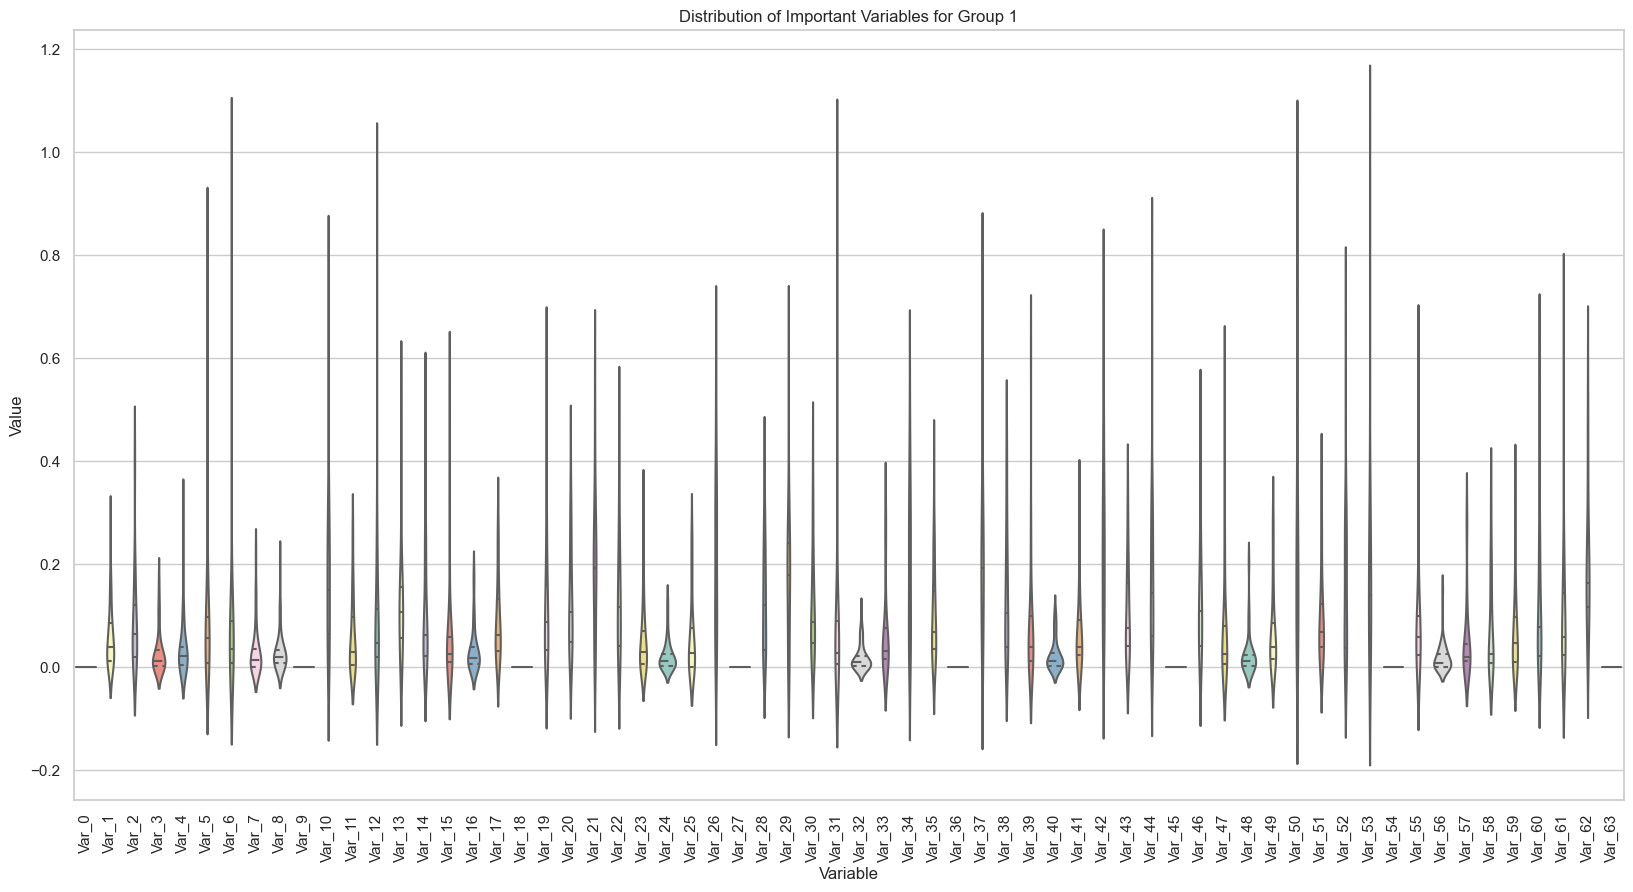

In [248]:
# Distribution plot for original df
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten the (79, 8, 8) array to (79, 64)
flattened_means = all_reordered_important_means.reshape(79, -1)

# Create a DataFrame for plotting
df_flattened_means = pd.DataFrame(flattened_means, columns=[f'Var_{i}' for i in range(flattened_means.shape[1])])

# Add the group labels to the DataFrame
df_flattened_means['group'] = df['group'].values

# Melt the DataFrame for easier plotting with seaborn
melted_df = df_flattened_means.melt(id_vars='group', var_name='Variable', value_name='Value')

print(melted_df.head())  # Check the first few rows

# Set the style for the plot
sns.set(style="whitegrid")

# Create a violin plot for the distribution of each variable, colored by group
plt.figure(figsize=(20, 10))
sns.violinplot(x='Variable', y='Value', hue='group', data=melted_df, split=True, inner='quart', palette='Set2')
plt.title('Distribution of Important Variables by Group')
plt.xticks(rotation=90)
plt.xlabel('Variable')
plt.ylabel('Value')
plt.legend(title='Group')
plt.show()


# Plot the distribution for each group separately
for group in df['group'].unique():
    plt.figure(figsize=(20, 10))
    sns.violinplot(x='Variable', y='Value', data=melted_df[melted_df['group'] == group], inner='quart', palette='Set3')
    plt.title(f'Distribution of Important Variables for Group {group}')
    plt.xticks(rotation=90)
    plt.xlabel('Variable')
    plt.ylabel('Value')
    plt.show()


In [1]:
# import numpy as np
# import pandas as pd
# import statsmodels.api as sm
# from sklearn.utils import resample
# from statsmodels.stats.multitest import multipletests
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Create DataFrames for Bootstrap and Permutation results
# bootstrap_df = pd.DataFrame(boot_results.T, columns=[f'ROI_{i}' for i in range(Y.shape[1])])
# permutation_df = pd.DataFrame(perm_results, columns=['Permutation_p_value'])

# # Original values DataFrame for plotting
# plot_df = pd.DataFrame({
#     'Value': Y.flatten(),  # Flatten Y to match length
#     'ROI': np.tile([f'ROI_{i}' for i in range(Y.shape[1])], Y.shape[0]),
#     'Group': np.repeat(X['group'].values, Y.shape[1])
# })

# # Plot the distribution of original values
# plt.figure(figsize=(14, 7))
# sns.histplot(data=plot_df, x='Value', hue='Group', multiple='stack', bins=30, kde=True)
# plt.title('Distribution of Original Values by Group')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.legend(title='Group')
# plt.show()

# # Flatten bootstrap results and create a DataFrame for plotting
# bootstrap_plot_df = pd.DataFrame({
#     'Coefficient': bootstrap_df.values.flatten(),
#     'Group': np.tile(X['group'].values, Y.shape[1] * n_bootstraps),
#     'ROI': np.repeat([f'ROI_{i}' for i in range(Y.shape[1])], n_bootstraps * X.shape[0])
# })

# # Plot the distribution of Bootstrap results
# plt.figure(figsize=(14, 7))
# sns.histplot(data=bootstrap_plot_df, x='Coefficient', hue='Group', multiple='stack', bins=30, kde=True)
# plt.title('Distribution of Bootstrap Results by Group')
# plt.xlabel('Bootstrap Coefficient')
# plt.ylabel('Frequency')
# plt.legend(title='Group')
# plt.show()

# # Flatten permutation results and create a DataFrame for plotting
# permutation_plot_df = pd.DataFrame({
#     'p_value': np.repeat(permutation_df['Permutation_p_value'].values, Y.shape[0]),
#     'Group': np.tile(X['group'].values, Y.shape[1])
# })

# # Plot the distribution of Permutation results
# plt.figure(figsize=(14, 7))
# sns.histplot(data=permutation_plot_df, x='p_value', hue='Group', multiple='stack', bins=30, kde=True)
# plt.title('Distribution of Permutation p-values by Group')
# plt.xlabel('Permutation p-value')
# plt.ylabel('Frequency')
# plt.legend(title='Group')
# plt.show()


In [ ]:
# Draw the nodes and edges, and color by weights
with PdfPages(pdf_file_name) as pdf:
    # Seed random number generators for reproducibility
    seed = 12

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes to the graph
    G.add_nodes_from(df_depna.columns)
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

    for i in range(i_size):
        not_nan_indices = ~np.isnan(p_values[i, :])
        # Perform FDR correction (Benjamini-Hochberg procedure)
        rejected, _, _, _ = multitest.multipletests(p_values[i, not_nan_indices], method='fdr_bh')
        # Update rejected array in place for non-NaN positions
        rejected_with_nan = np.full_like(p_values[i, :], False)
        rejected_with_nan[not_nan_indices] = rejected

        for j in range(j_size):
            if i != j and not np.isnan(p_values[i, j]) and rejected_with_nan[j] and t_values[i, j] < 0:
                t_value = abs(t_values[i, j])
                arrow_color = 'dimgray'
                G.add_edge(df_depna.columns[i], df_depna.columns[j], weight=t_value, arrow_color=arrow_color)

    # Use circular layout for the graph
    pos = nx.circular_layout(G)  # can choose different layout algorithms

    # Draw edges with edge thickness based on weight and arrow color
    labels = {node: node for node in G.nodes()}
    edge_weights = [abs(G[edge[0]][edge[1]]['weight']) * 1 for edge in G.edges()]  # Adjust the multiplier for edge thickness
    arrow_colors = [G[edge[0]][edge[1]]['arrow_color'] for edge in G.edges()]

    nx.draw_networkx_edges(G, pos, alpha=1, arrowsize=15, width=edge_weights, edge_color=arrow_colors, connectionstyle='arc3,rad=0.1')

    for ii in range(i_size):
        for jj in range(j_size):
            if ii != jj and p_values[ii, jj] <= 0.05 and t_values[ii, jj] < 0:
                t_value = abs(t_values[ii, jj])
                arrow_color = 'lightgray'
                G.add_edge(df_depna.columns[ii], df_depna.columns[jj], weight=t_value, arrow_color=arrow_color)

    nx.draw_networkx_edges(G, pos, alpha=0.5, arrowsize=15, width=edge_weights, edge_color=arrow_colors, connectionstyle='arc3,rad=0.1')

    # Draw the nodes with colors and transparency based on SLI_t_values
    colorsT = (-1) * SLI_t_values
    cmap = plt.cm.jet  # colormap
    norm = plt.Normalize(colorsT.min(), colorsT.max())  # Normalize the values
    rgba_colors = cmap(norm(colorsT))  # Get RGBA colors from the colormap

    # Set transparency level
    alpha = 1  # Change this value to set the transparency level
    rgba_colors[:, 3] = alpha

    # Draw the graph with nodes colored using the modified RGBA colors
    nx.draw_networkx_nodes(G, pos, node_size=400, node_color=rgba_colors)

    # Optionally draw labels if needed
    # nx.draw(G, pos, with_labels=True, labels=labels, node_size=700, node_color='skyblue', font_color='black', font_size=10)

    # Save the figure to the PDF
    pdf.savefig()
    plt.close()
